In [1]:
from datetime import timedelta

import more_itertools
import numpy
import xarray

from matplotlib import pyplot
from sklearn import decomposition, linear_model, manifold

from tom.matplotlib import axes_iter

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
LABEL_TEMPERATURE = r'Temperature / $^\circ\mathrm{C}$'

In [4]:
dataset = xarray.open_dataset('data/cat_tave_selectvars_500yrs.nc')

In [5]:
# Each timestep is one month.
print(numpy.unique(numpy.diff(dataset.T.values) / timedelta(days=1).total_seconds()))

[30.]


In [6]:
# Dataset is in order (T, Z [depth], Y [latitude], X [longitude])
ttave = dataset.Ttave.values
print(ttave.shape)

(6001, 42, 78, 11)


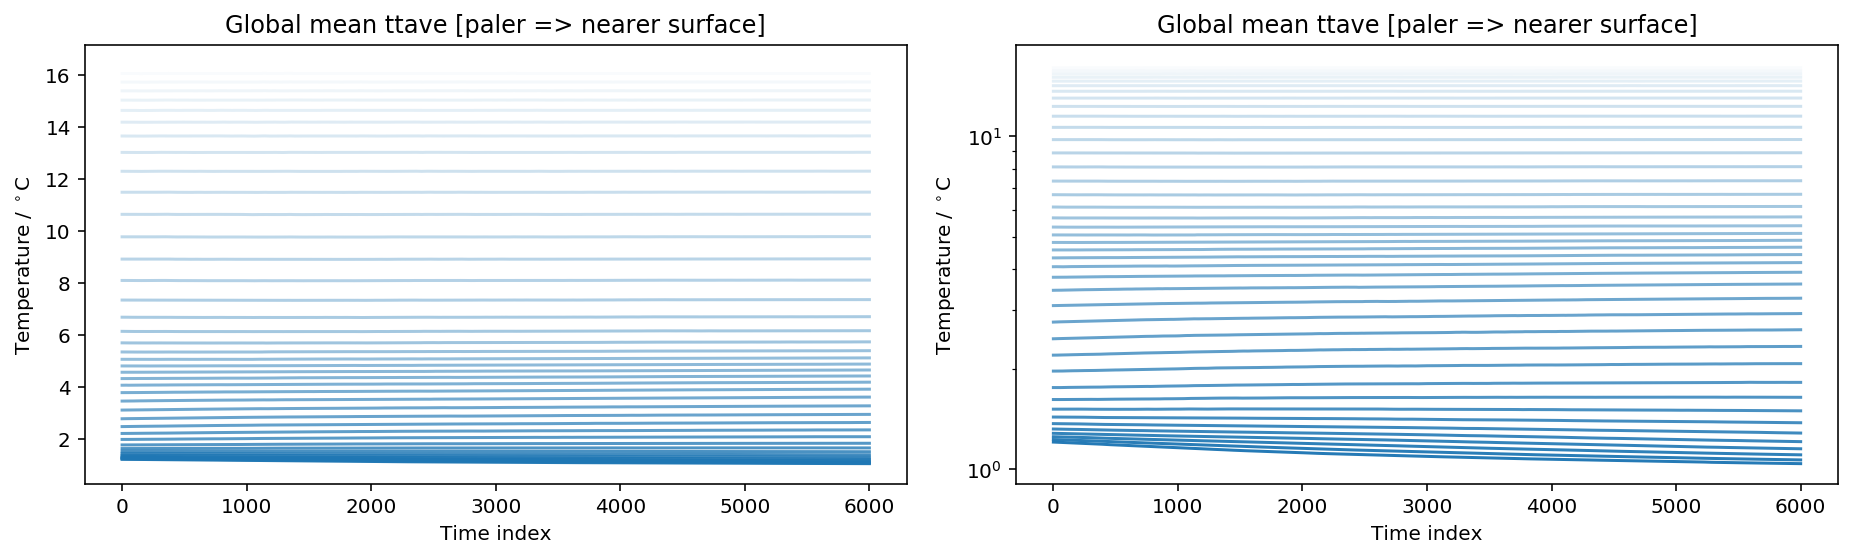

In [7]:
# Question - how does the temperature vary with height, roughly speaking?
# Interesting to see moderately rapid evolution over time, particularly at lower levels.

for use_log in axes_iter([False, True], num_cols=2):
    average_ttave = numpy.mean(ttave, axis=(2, 3))  # Time, Z
    # pyplot.plot(average_ttave[:, -10], c='C0')  # GARBAGE - trying to inspect more detailed time variation.
    for i, moo in enumerate(average_ttave.T):
        pyplot.plot(moo, c='C0', alpha=i / average_ttave.shape[1])
    pyplot.title('Global mean ttave [paler => nearer surface]')
    if use_log:
        pyplot.yscale('log')
    pyplot.xlabel('Time index')
    pyplot.ylabel(r'Temperature / $^\circ\mathrm{C}$')

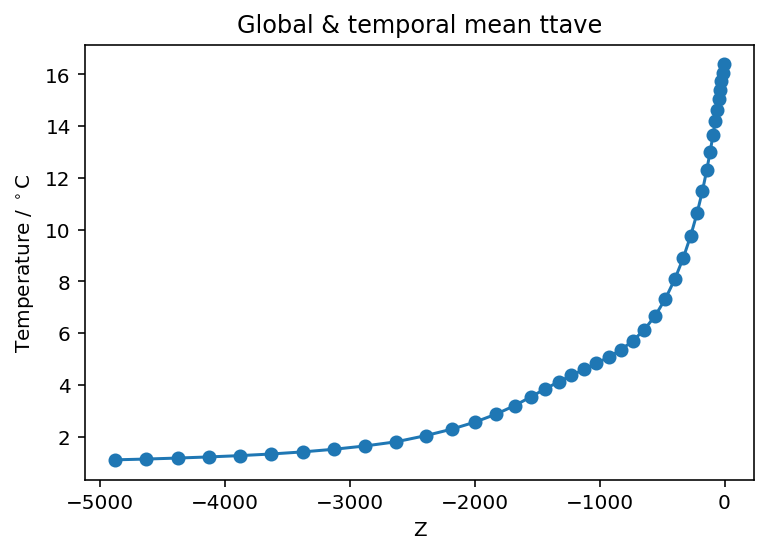

In [8]:
# Additionally average over all time for greater clarity.
average_ttave = numpy.mean(ttave, axis=(0, 2, 3))  # Z
pyplot.plot(dataset.Z.values, average_ttave, marker='o')
pyplot.title('Global & temporal mean ttave')
pyplot.xlabel('Z')
pyplot.ylabel(LABEL_TEMPERATURE)
pyplot.show()

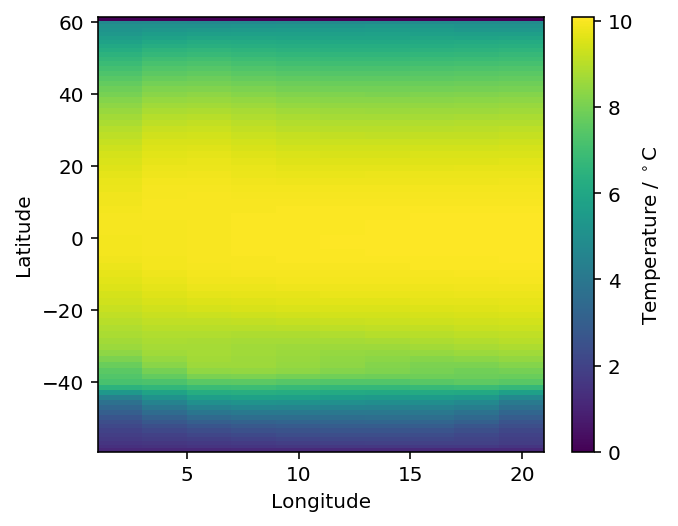

In [9]:
# Question - how does temperature vary over latitude & longitude?
pyplot.figure(figsize=(5, 4))
pyplot.pcolormesh(dataset.X.values, dataset.Y.values, numpy.mean(dataset.Ttave.values, axis=(0, 1)))
pyplot.xlabel('Longitude')
pyplot.ylabel('Latitude')
colorbar = pyplot.colorbar()
colorbar.set_label(LABEL_TEMPERATURE)
pyplot.show()

In [124]:
def plot_z_layers(to_plot: numpy.ndarray, dataset: xarray.Dataset, feature_label: str, symmetric_about_zero: bool = False):
    """Plot a metric for all layers of the ocean using a grid of 2D images.
    
    :param to_plot: ndarray of shape (nZ, nX, nY), matching up with `dataset`.
    :param dataset: The underlying dataset, used for co-ordinate labels.
    :param feature_label: Used to label the colorbar.
    :param symmetric_about_zero: Iff true, make a colour rendering that is symmetric about zero. This will also use
        a diverging colormap.
    """
    for i_z, z in axes_iter(enumerate(dataset.Z.values), num_cols=21, width=16, height=2, sharex=True,
                            sharey=True, shared_ylabel='Latitude',
                            clim_convex_hull=True, tight_layout=False):
        to_plot_z_layer = to_plot[i_z]
        
        if symmetric_about_zero:
            vmax = numpy.max(abs(to_plot_z_layer))
            vmin = -vmax
            cmap = 'bwr'
        else:
            vmin = numpy.min(to_plot_z_layer)
            vmax = numpy.max(to_plot_z_layer)
            cmap = 'viridis'

        # Remove space between figures...
        pyplot.gcf().subplots_adjust(hspace=.025, wspace=.05)
        
        # There isn't room for showing the z-depth. A bit sad, but let's hope that the user reads the code to figure
        # out what is going on! The top-left is the top of the ocean, and bottom-right is the bottom.
        # pyplot.title(f'{z:.2f}m')
        # FIXME need cell edges for Y - this is currently skipping data! But this is what is done in RF's code?
        pyplot.pcolormesh(dataset.Xp1.values, dataset.Y.values, to_plot_z_layer, vmin=vmin, vmax=vmax, cmap=cmap)


    # Slightly hacky... only show these axes labels in the final plot.
    pyplot.xlabel('Longitude')
    colorbar = pyplot.colorbar()
    colorbar.set_label(feature_label)    

In [125]:
def plot_all_ttaves(i_t: int, dataset: xarray.Dataset):
    """Plot the average temperate (Ttave) at all heights, latitudes & longitudes.
    
    :param i_t: The index of the reference time.
    :param dataset: The full xarray dataset.
    """
    plot_z_layers(dataset.Ttave[i_t].values, dataset, LABEL_TEMPERATURE)

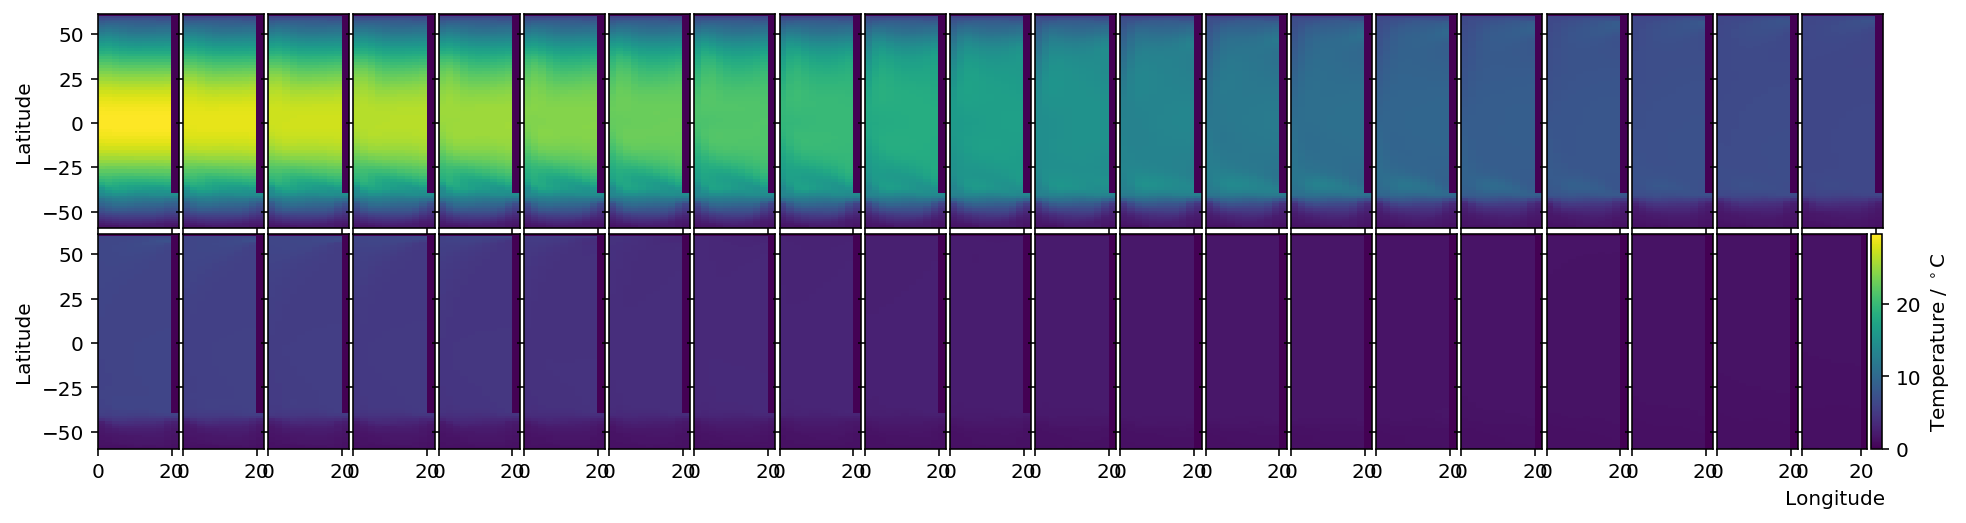

In [126]:
plot_all_ttaves(0, dataset)

In [127]:
def plot_all_differences(i_t0: int, i_t1: int, dataset: xarray.Dataset):
    """Plot the differences at all heights, latitudes & longitudes.
    
    :param i_t0: The index of the first reference time.
    :param i_t1: The index of the second reference time.
    :param dataset: The full xarray dataset.
    """
    ttave = dataset['Ttave'].values
    diff = ttave[i_t1] - ttave[i_t0]
    plot_z_layers(diff, dataset, LABEL_TEMPERATURE, symmetric_about_zero=True)

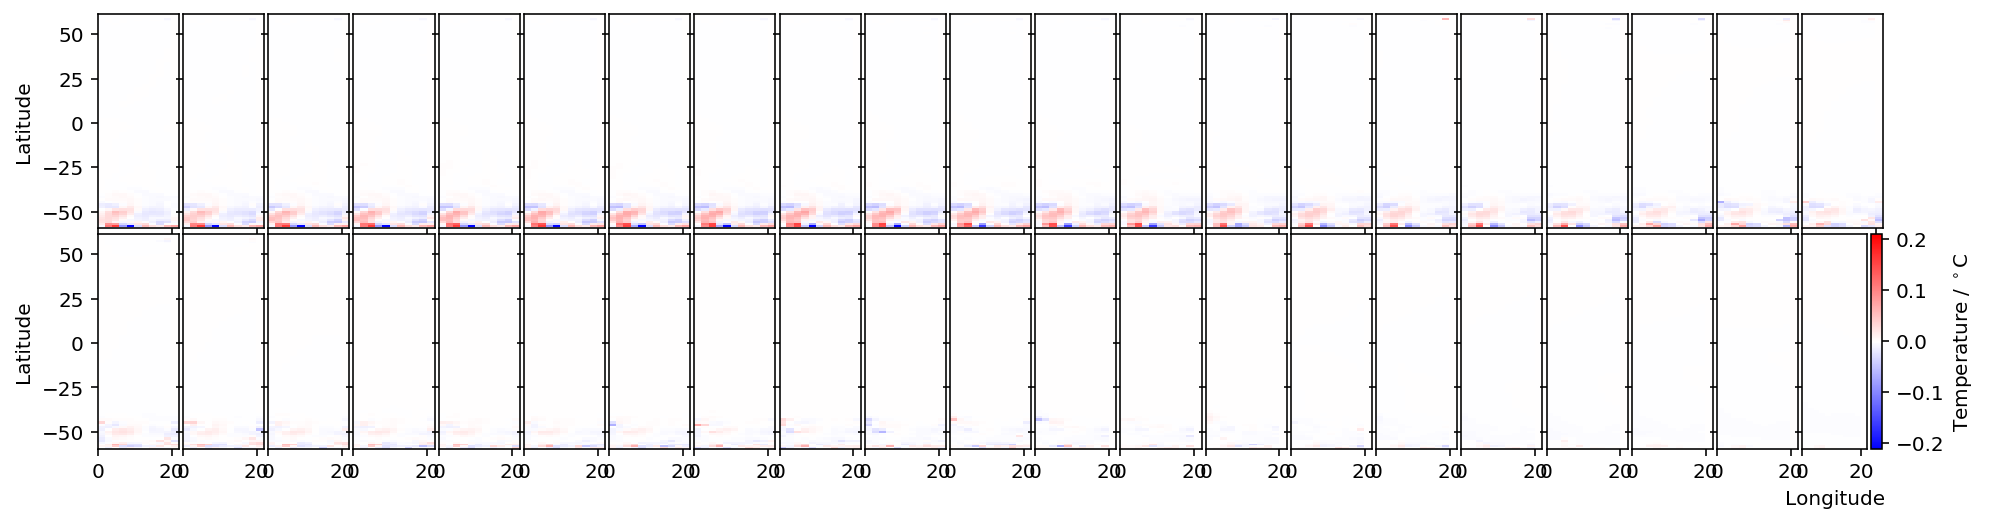

In [128]:
plot_all_differences(0, 10, dataset)

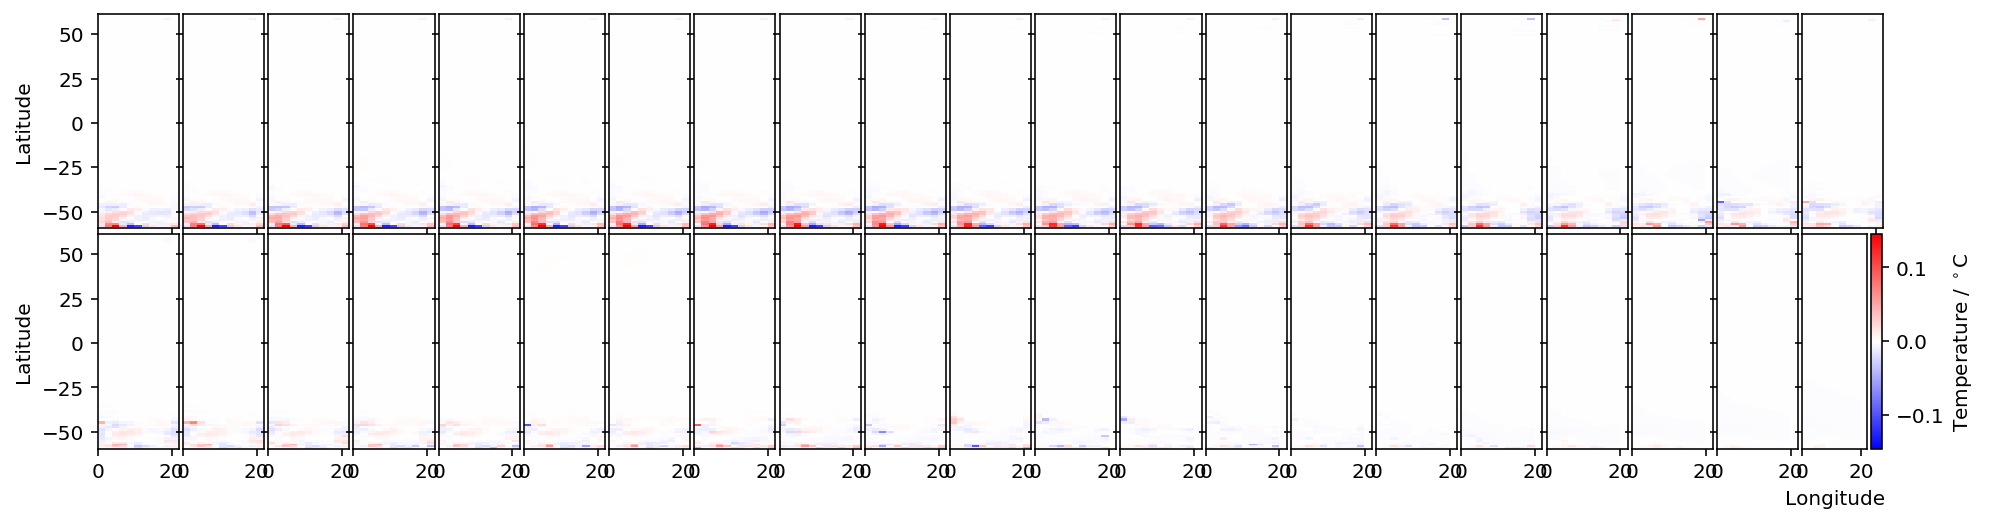

In [129]:
plot_all_differences(5, 15, dataset)

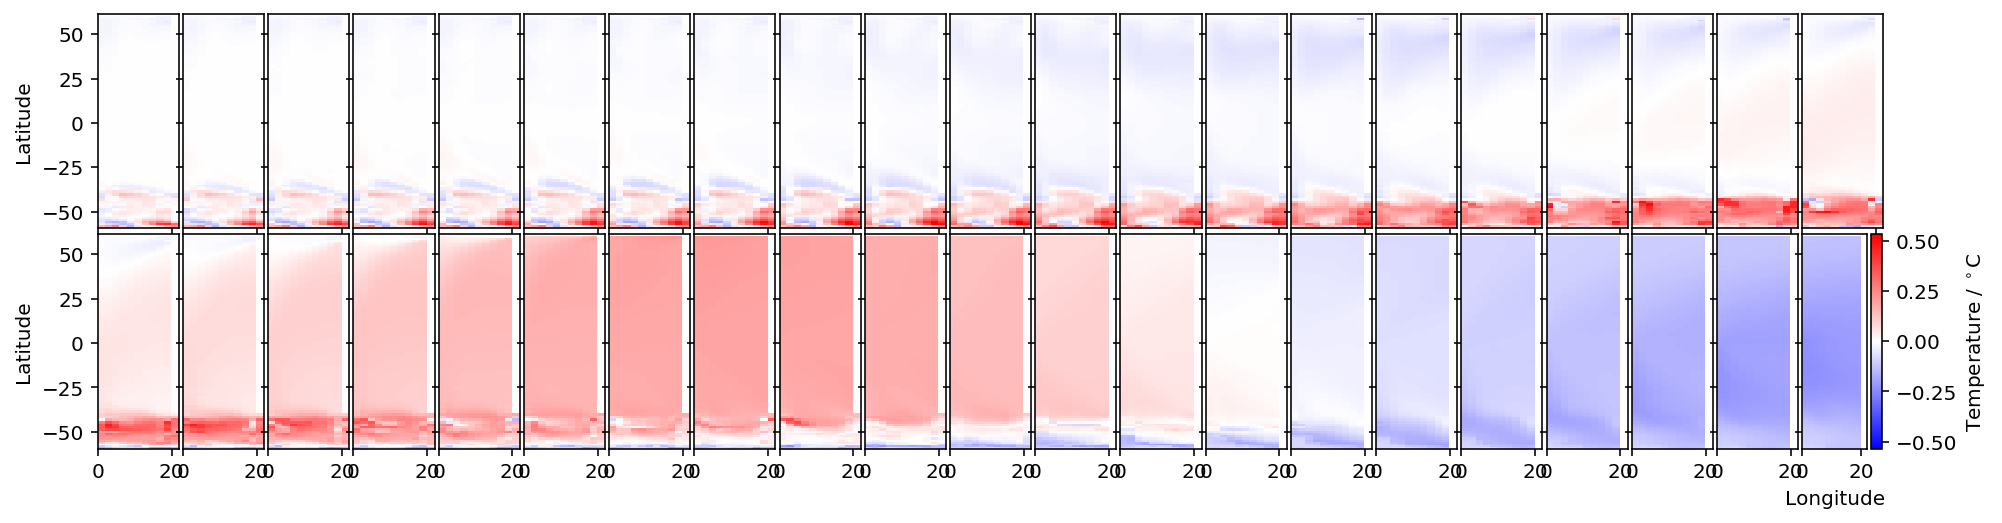

In [130]:
plot_all_differences(0, 5000, dataset)

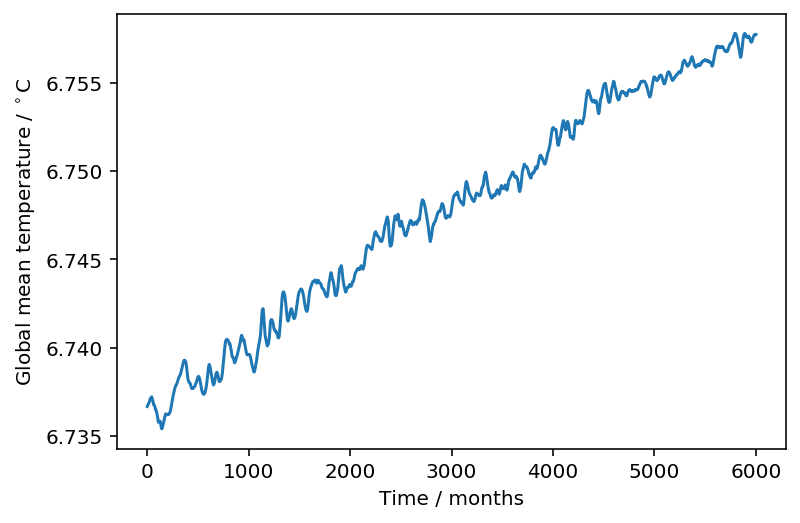

In [131]:
# Do we have any basic conservation properties? Global mean temperature appears to not
# be conserved. Presumably this stems from something important?
pyplot.plot(numpy.mean(ttave, axis=(1, 2, 3)))
pyplot.xlabel('Time / months')
pyplot.ylabel(r'Global mean temperature / $^\circ\mathrm{C}$')
pyplot.show()

## Tom F's cool plots

In [132]:
dataset.Z[3]

<xarray.DataArray 'Z' ()>
array(-35.8)
Coordinates:
    Z        float64 -35.8
Attributes:
    long_name:  vertical coordinate of cell center
    units:      meters
    positive:   up

In [133]:
dataset.T.values

array([1.5577920e+09, 1.5603840e+09, 1.5629760e+09, ..., 1.7104608e+10,
       1.7107200e+10, 1.7109792e+10])

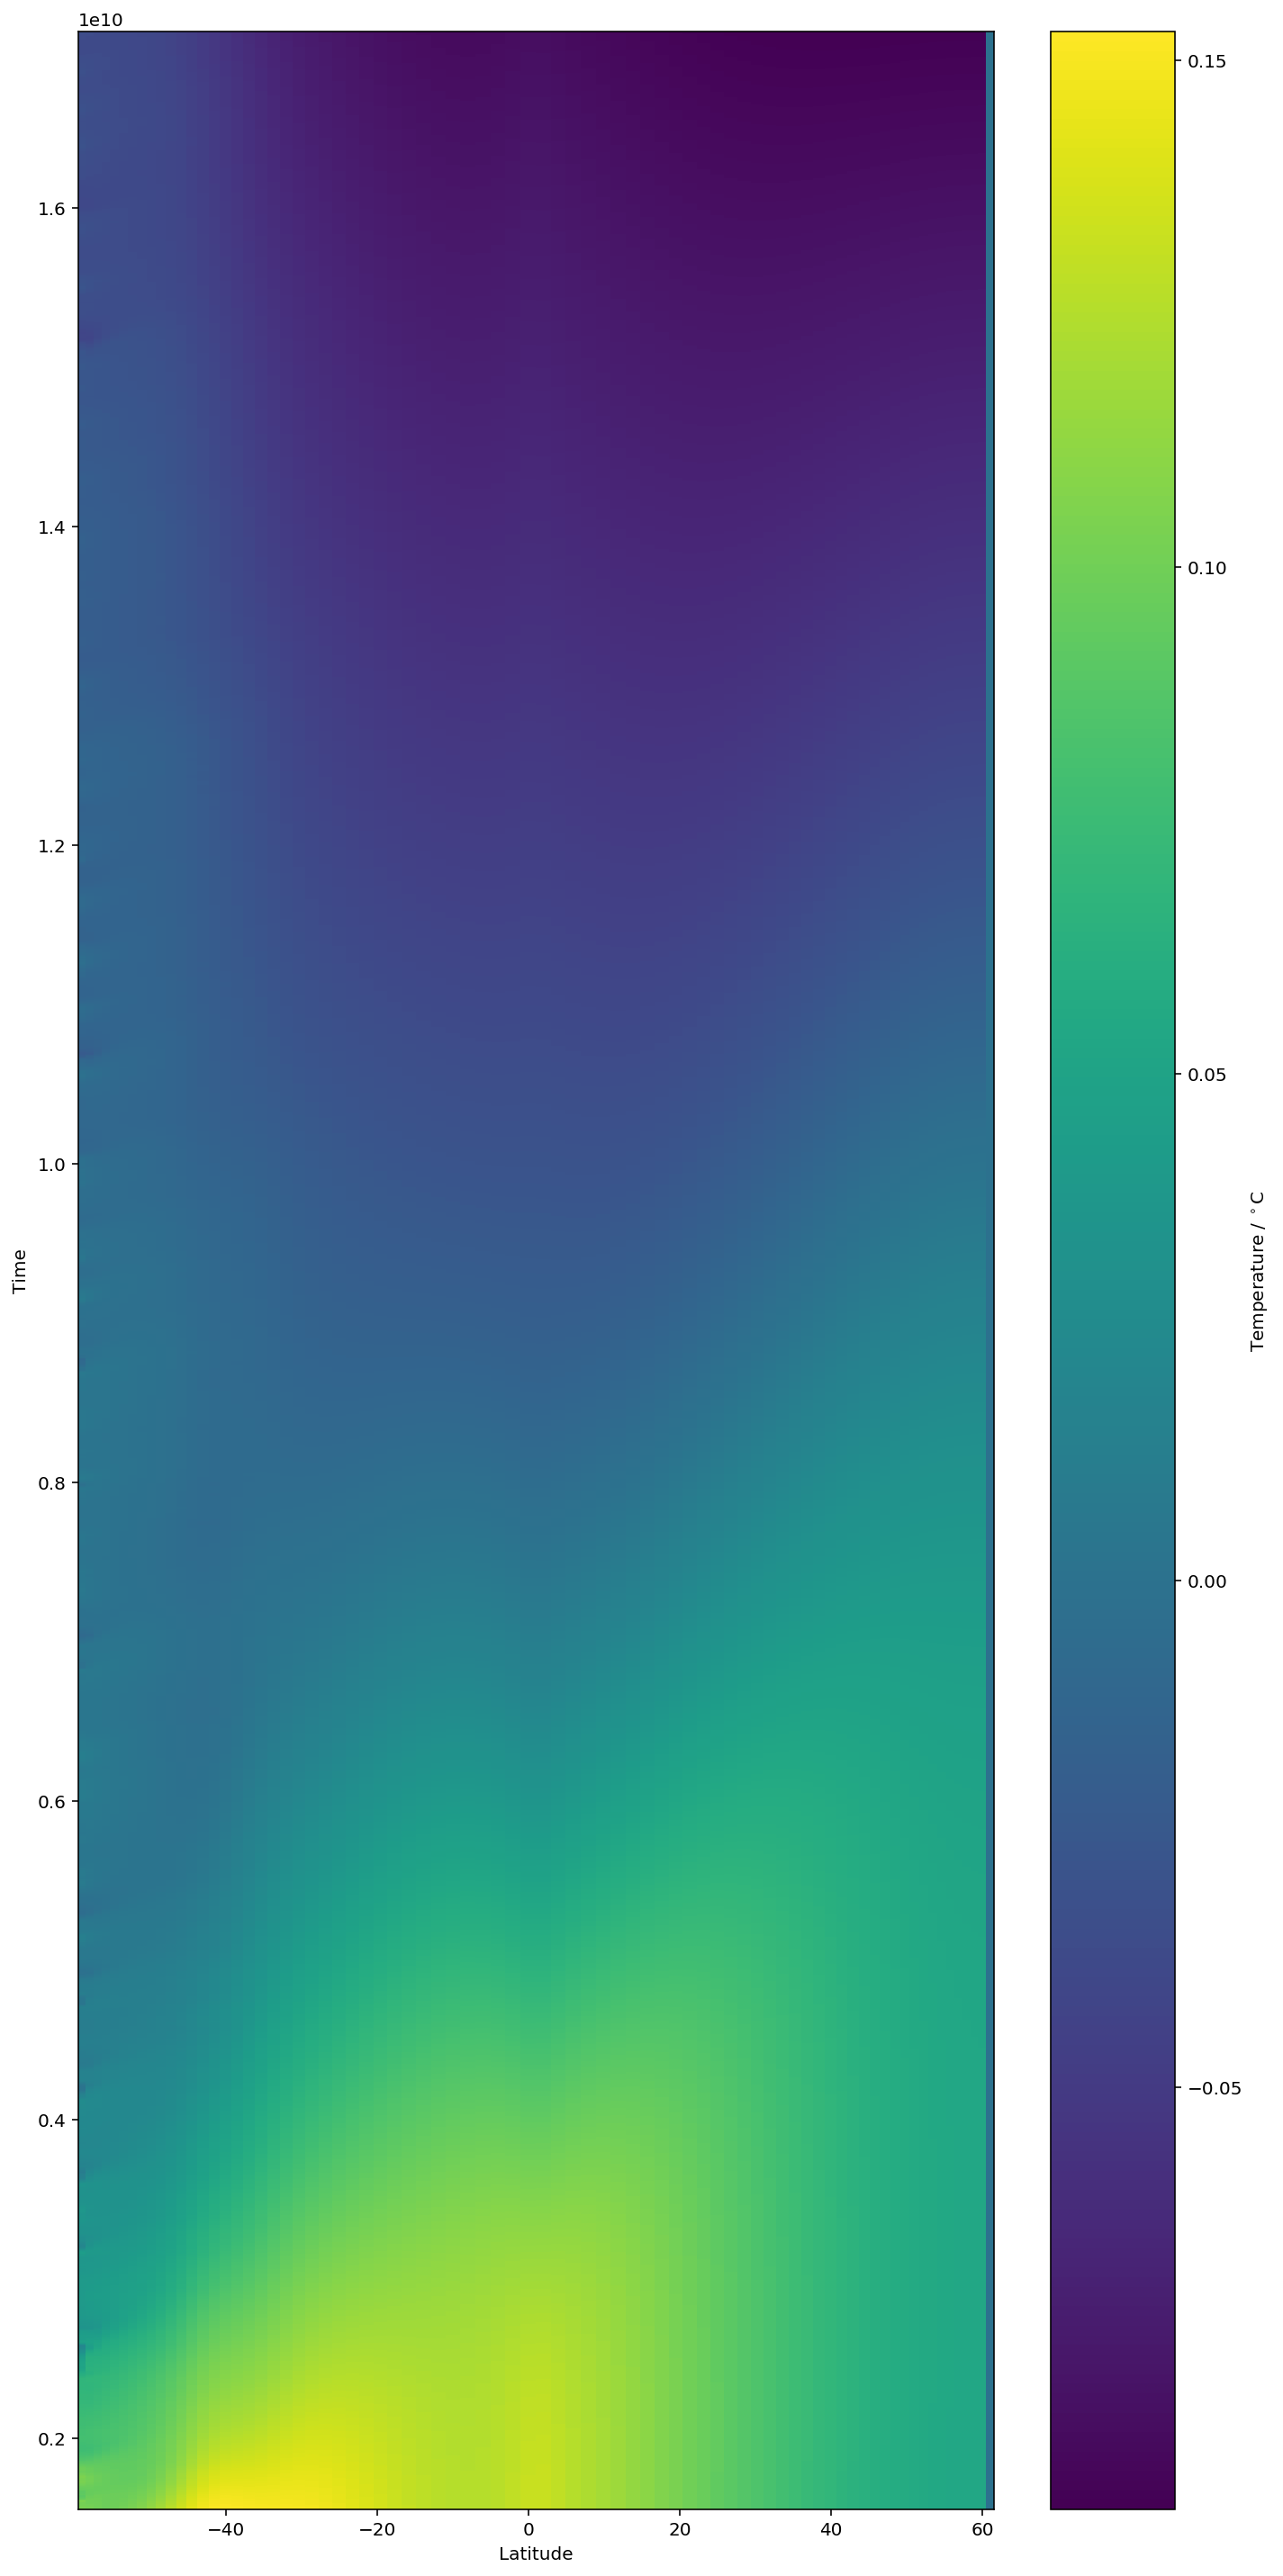

In [134]:
# moo = dataset.uVeltave.values - numpy.mean(dataset.uVeltave.values, axis=0, keepdims=True)
moo = dataset.Ttave.values - numpy.mean(dataset.Ttave.values, axis=0, keepdims=True)

pyplot.figure(figsize=(10, 20))
pyplot.pcolormesh(dataset.Y.values, dataset.T.values, moo[:, 40, :, 5])
pyplot.xlabel('Latitude')
pyplot.ylabel('Time')
colorbar = pyplot.colorbar()
colorbar.set_label(LABEL_TEMPERATURE)
pyplot.tight_layout()
pyplot.show()

In [135]:
dataset.Y

<xarray.DataArray 'Y' (Y: 78)>
array([-59.5    , -58.48445, -57.4375 , -56.3586 , -55.2472 , -54.10275,
       -52.92475, -51.71275, -50.46635, -49.1852 , -47.869  , -46.51745,
       -45.1304 , -43.7078 , -42.24955, -40.7557 , -39.23385, -37.6849 ,
       -36.10245, -34.48695, -32.83895, -31.15915, -29.4484 , -27.7076 ,
       -25.9378 , -24.14025, -22.31625, -20.4672 , -18.59465, -16.7003 ,
       -14.786  , -12.85365, -10.90525,  -8.9429 ,  -6.96875,  -4.9851 ,
        -2.9943 ,  -0.9987 ,   0.9987 ,   2.9943 ,   4.9851 ,   6.96875,
         8.9429 ,  10.90525,  12.85365,  14.786  ,  16.7003 ,  18.59465,
        20.4672 ,  22.31625,  24.14025,  25.9378 ,  27.7076 ,  29.4484 ,
        31.15915,  32.83895,  34.48695,  36.10245,  37.6849 ,  39.23385,
        40.7557 ,  42.24955,  43.7078 ,  45.1304 ,  46.51745,  47.869  ,
        49.1852 ,  50.46635,  51.71275,  52.92475,  54.10275,  55.2472 ,
        56.3586 ,  57.4375 ,  58.48445,  59.5    ,  60.5    ,  61.5    ])
Coordinates:
  * Y 

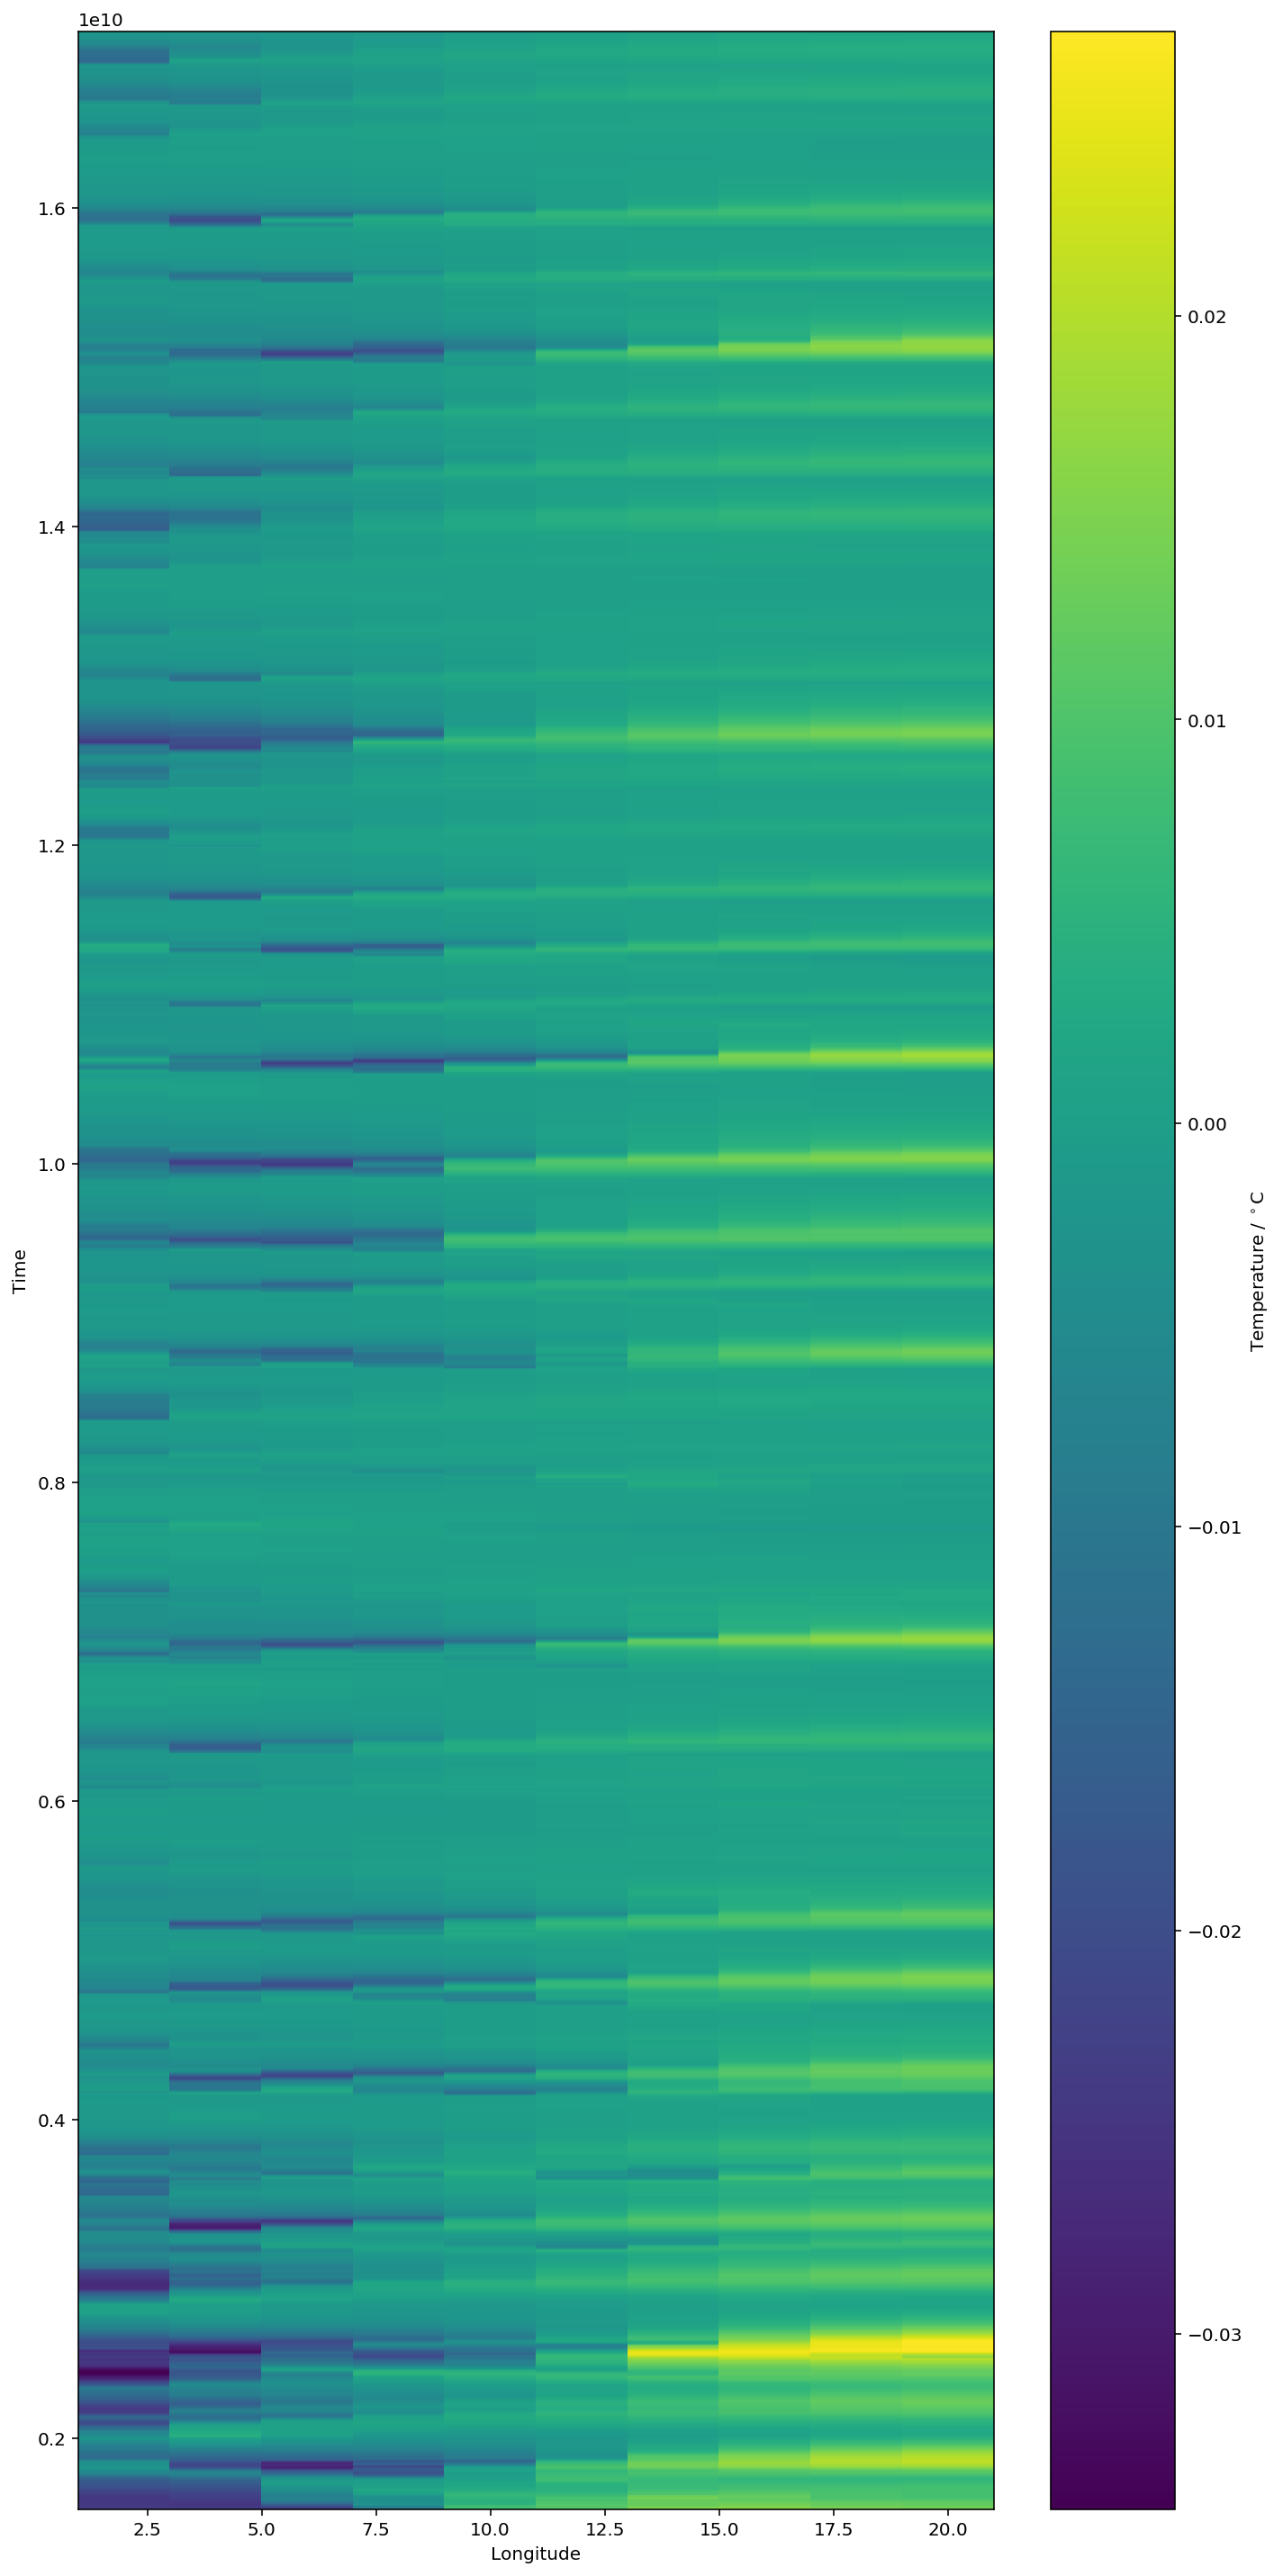

In [136]:
# moo = dataset.uVeltave.values - numpy.mean(dataset.uVeltave.values, axis=0, keepdims=True)
moo = dataset.Ttave.values - numpy.mean(dataset.Ttave.values[:, :, :, :-1], axis=3, keepdims=True)

pyplot.figure(figsize=(10, 20))
pyplot.pcolormesh(dataset.X.values, dataset.T.values, moo[:, 41, 0, :]) #, cmap='bwr', vmin=-.03, vmax=.03)
# pyplot.pcolormesh(moo[:, 40, 0, :])
pyplot.xlabel('Longitude')
pyplot.ylabel('Time')
colorbar = pyplot.colorbar()
colorbar.set_label(LABEL_TEMPERATURE)
pyplot.tight_layout()
pyplot.show()

In [137]:
moo[:, 40, 0, :]

array([[-2.54755020e-02, -2.56134272e-02, -3.00279856e-02, ...,
         1.77409649e-02,  1.25620365e-02, -1.18889892e+00],
       [-2.56712437e-02, -2.59255171e-02, -2.99850702e-02, ...,
         1.76821947e-02,  1.25491619e-02, -1.18915057e+00],
       [-2.58193016e-02, -2.62123346e-02, -2.97896862e-02, ...,
         1.76548958e-02,  1.25641823e-02, -1.18938279e+00],
       ...,
       [-1.84786320e-03, -2.20632553e-03, -2.13718414e-03, ...,
         1.42228603e-03, -2.02775002e-04, -1.06928885e+00],
       [-1.94597244e-03, -2.27165222e-03, -2.16984749e-03, ...,
         1.34992599e-03, -2.75015831e-04, -1.06932092e+00],
       [-2.07531452e-03, -2.33042240e-03, -2.21574306e-03, ...,
         1.28030777e-03, -3.29256058e-04, -1.06935239e+00]], dtype=float32)

# Simple PCA
Very simple approach to being with - start by doing PCA of the state space. This will not necessarily be the best basis in which to express the *changes*, which is ultimately what we will care about, but it seems like a reasonable place to start.

The basic approach is:

1. **Find principal components**: in practice we do this in a "flattened" space of shape (Z x Y x X,), then project back to (Z, Y, X).
1. **Visualise**: We can visualise each principal component in the original basis. The mean is, effectively a separate component.
1. **Project**: Next, each time-step can be projected onto the principal components... this is a form of compression. We can then inspect:
    1. How do the coefficients evolve over time?
    1. What is the reconstruction error?
    1. How do both of the above vary with the number of PCs used in the decomposition?

In [138]:
# Only fit the model on this many timesteps. We will then see how well the model can describe the full dataset.
i_t_in_sample = 3000

In [139]:
# Squash the non-time dimensions. This is required to fit the API of sklearn.
print(ttave.shape)
flat_ttave = ttave.reshape(ttave.shape[0], -1)
print(flat_ttave.shape)

(6001, 42, 78, 11)
(6001, 36036)


In [140]:
model = decomposition.PCA(1000)
model.fit(flat_ttave[:i_t_in_sample])

PCA(copy=True, iterated_power='auto', n_components=1000, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

### Explained variance
In principle, this gives us an idea of how many principal components are required to adequately explain the data. Most likely we should be considering this in terms of *differences* in order to be more meaningful, but one step at a time...

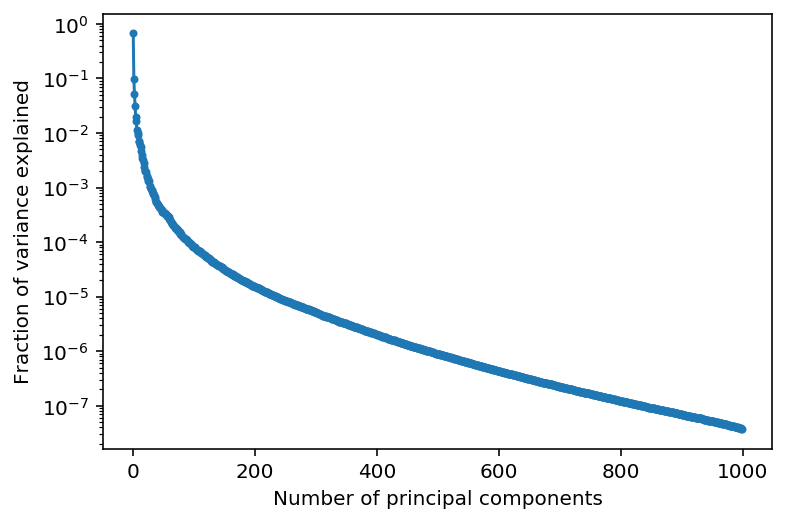

In [141]:
pyplot.plot(model.explained_variance_ratio_, marker='.')
pyplot.xlabel('Number of principal components')
pyplot.ylabel('Fraction of variance explained')
pyplot.yscale('log')
pyplot.show()

### Mean

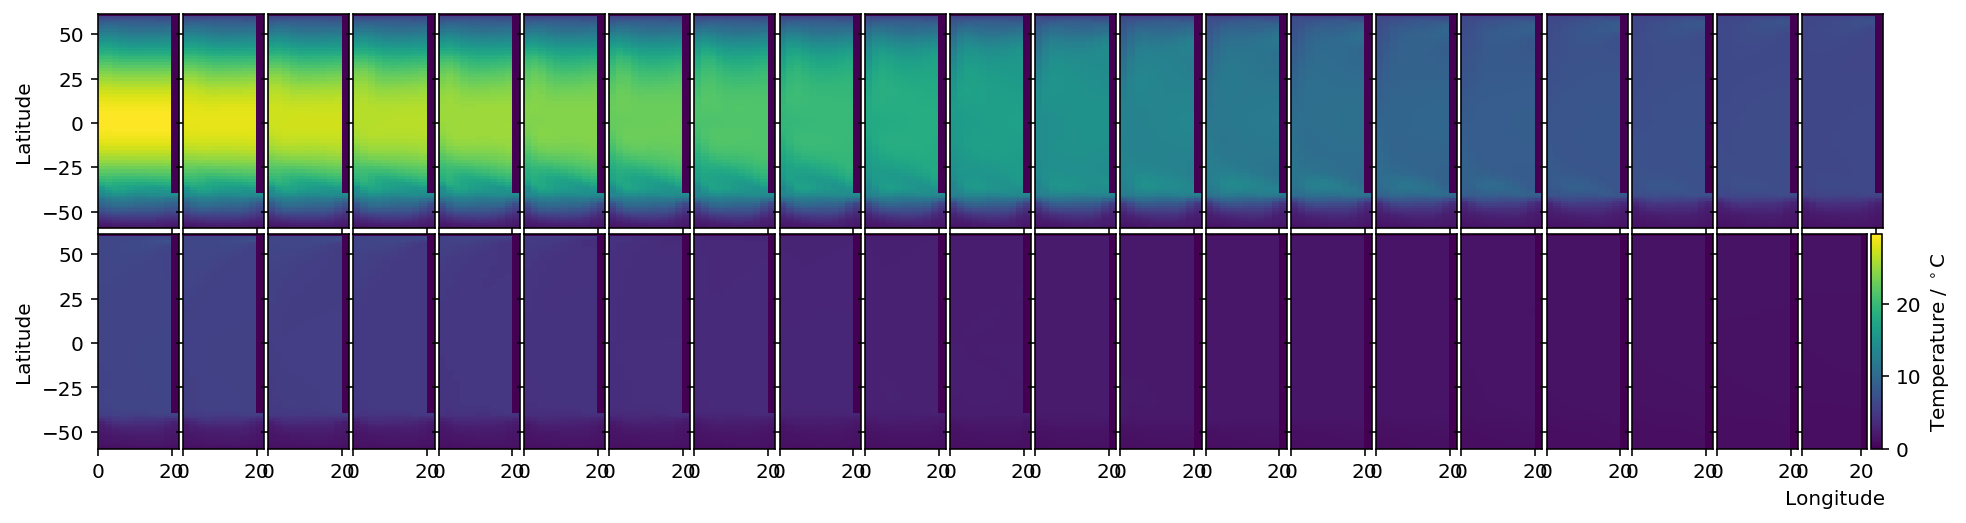

In [142]:
mean = model.mean_.reshape(ttave.shape[1:])
plot_z_layers(mean, dataset, LABEL_TEMPERATURE)

### Principal components
For sake of keeping the notebook of finite size, only show first five.

Principal component: 0


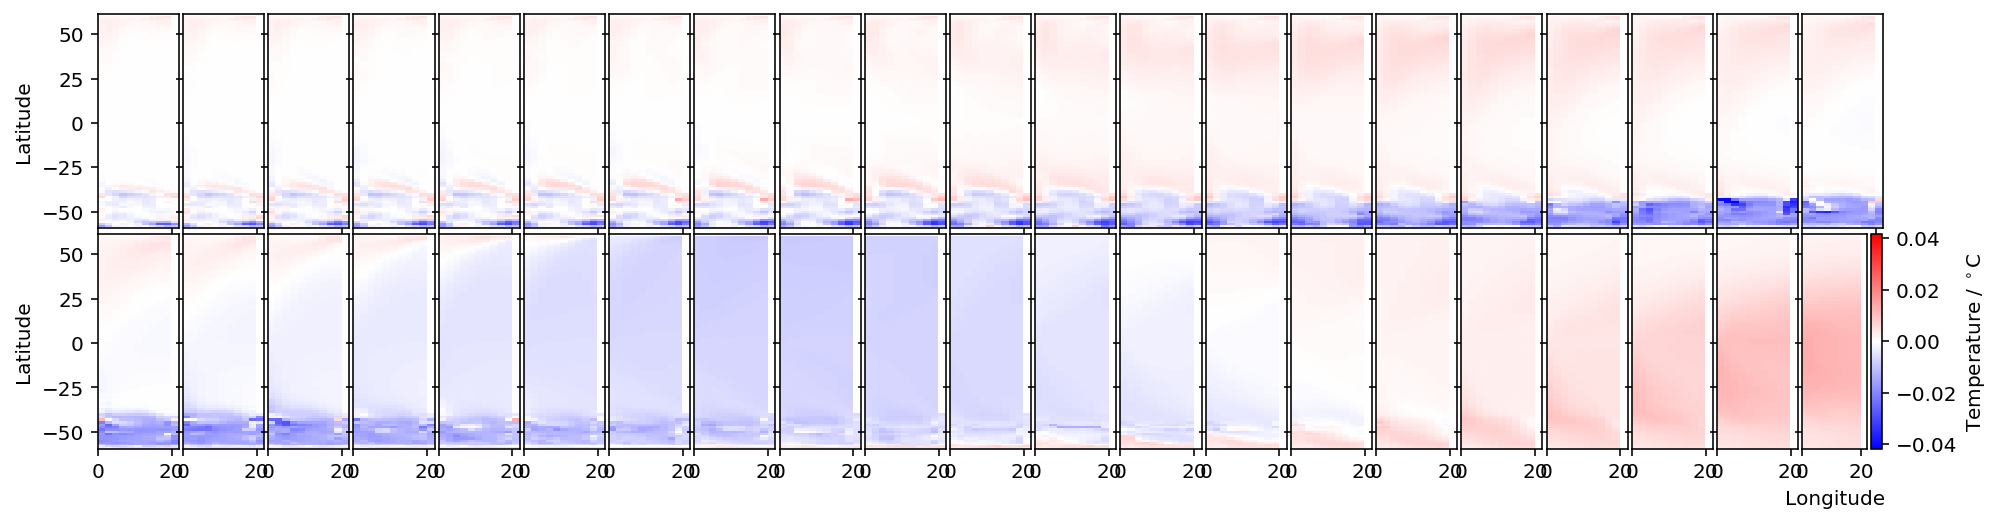


Principal component: 1


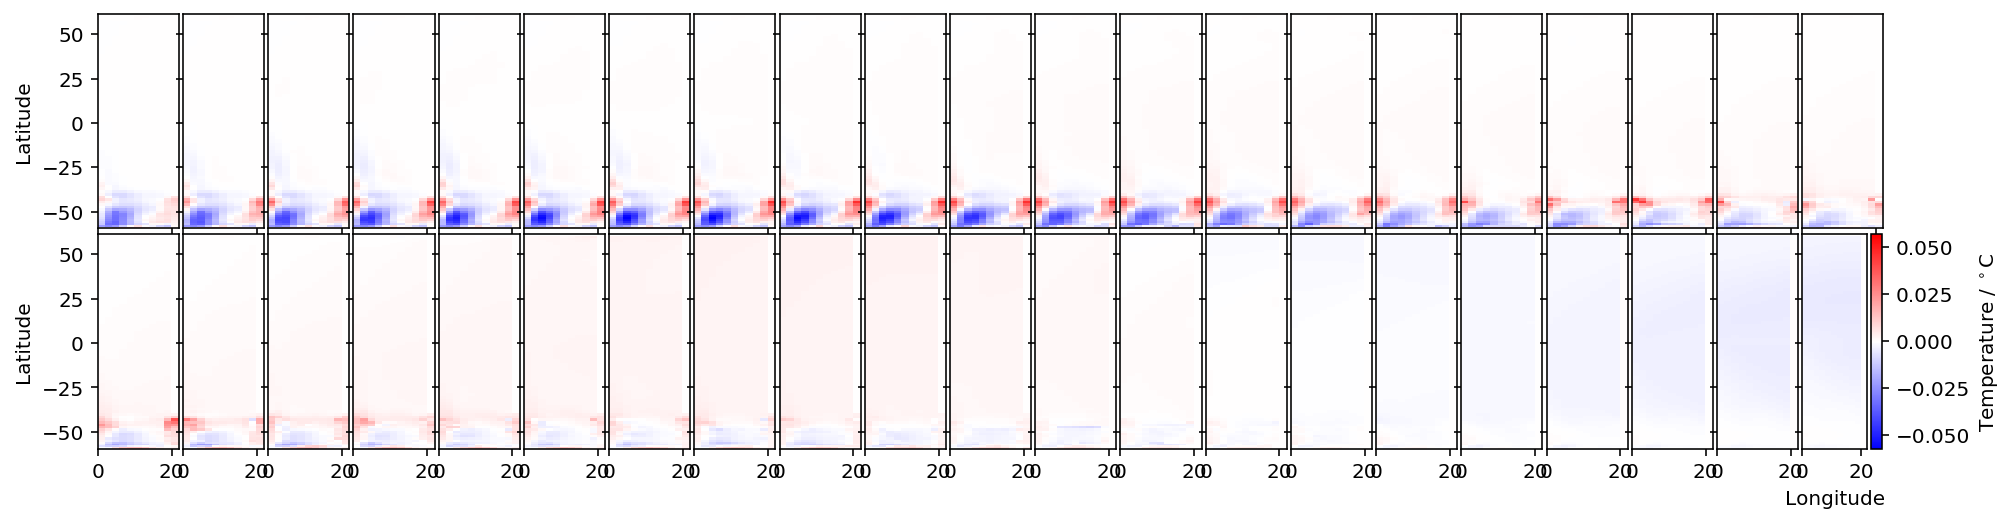


Principal component: 2


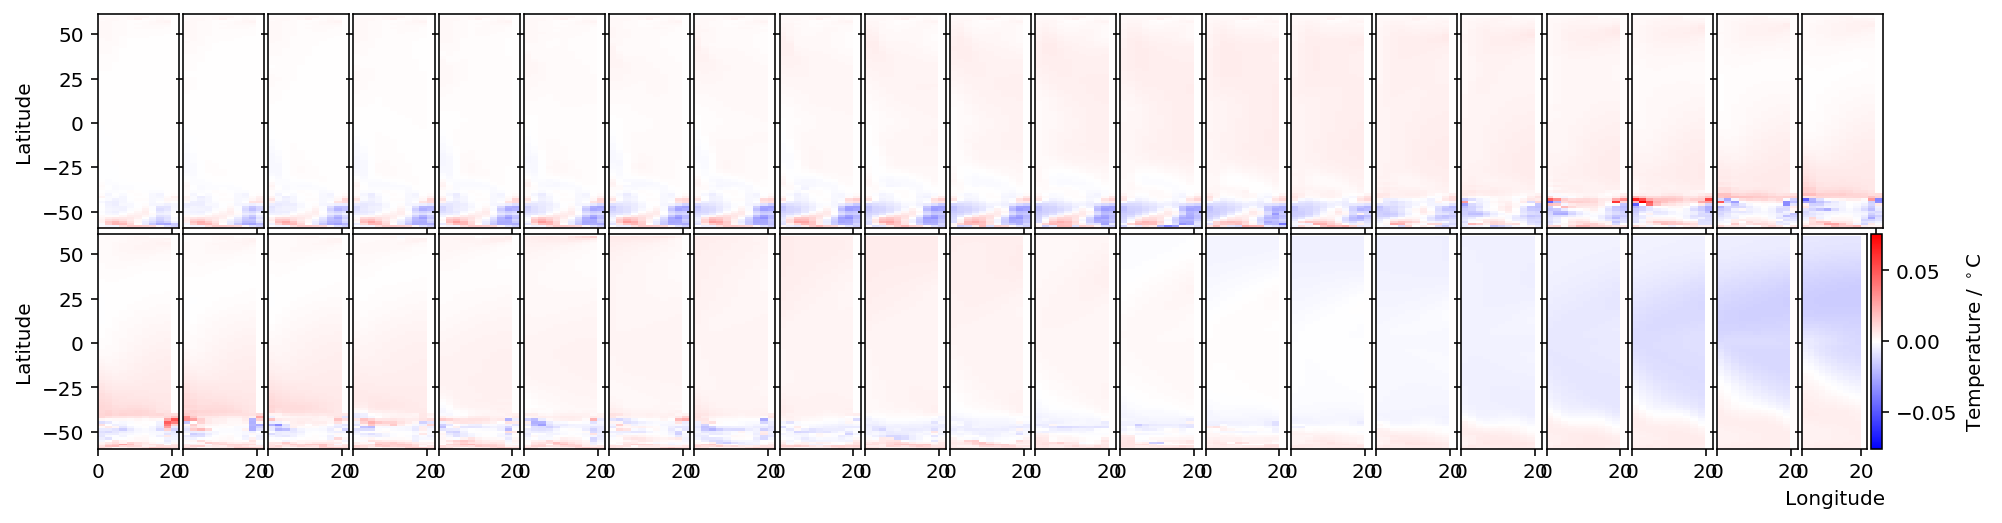


Principal component: 3


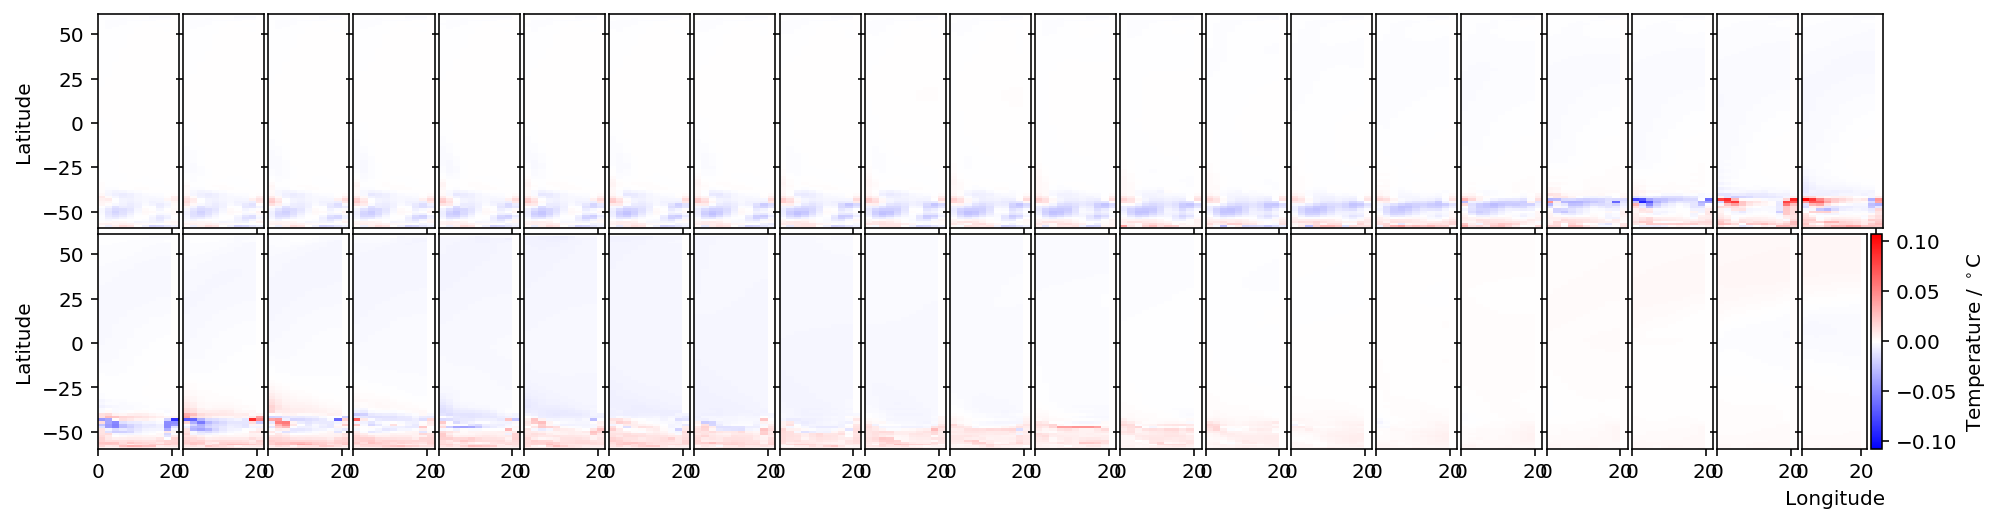


Principal component: 4


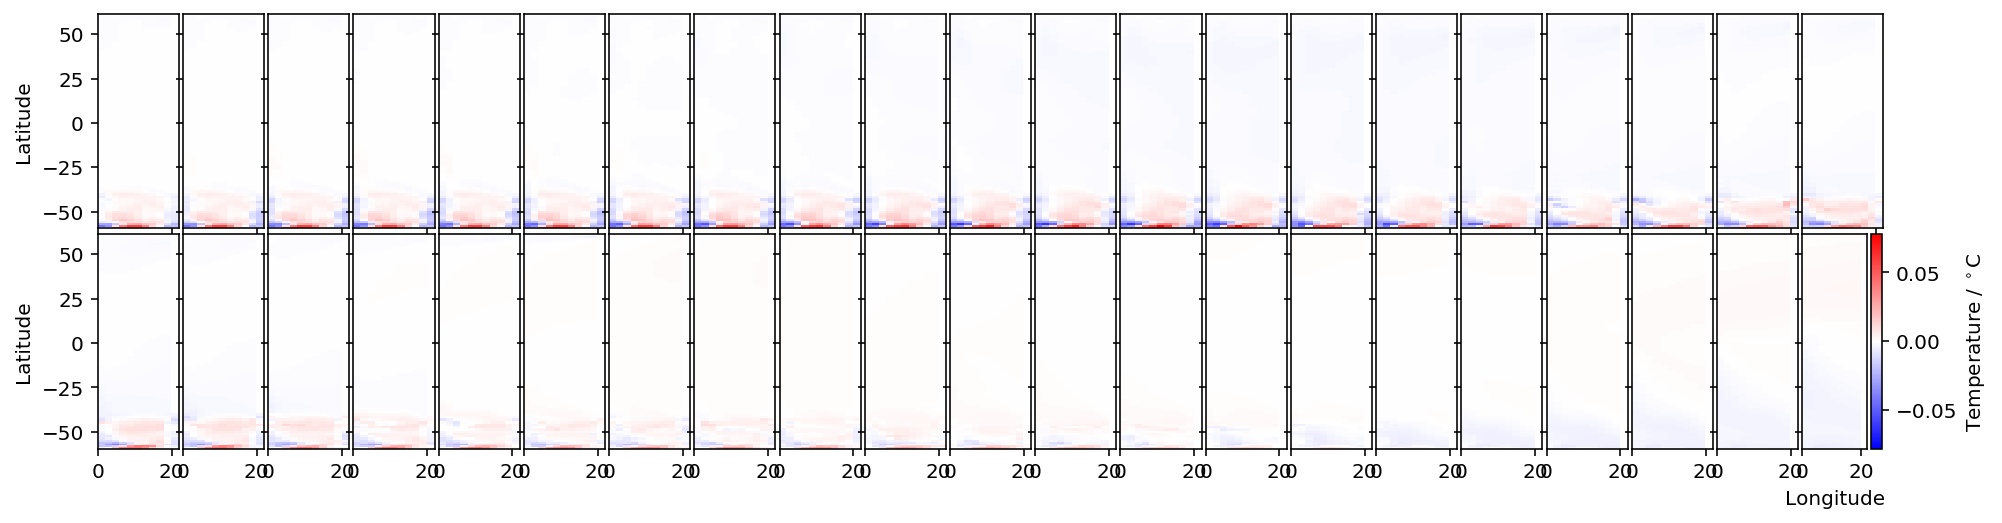

In [143]:
# FactorAnalysis and PCA normalise the factors differently. normalisation will be a vector of ones for PCA (or 
# numerically close to that), but for FactorAnalysis it will be significantly decaying.
normalisation = numpy.sqrt(numpy.sum(model.components_ ** 2, axis=1))

pca_components = (model.components_ / numpy.expand_dims(normalisation, axis=1)).reshape(-1, *ttave.shape[1:])
for i_pc, pc in enumerate(pca_components[:5]):
    print(f'Principal component: {i_pc}')
    plot_z_layers(pc, dataset, LABEL_TEMPERATURE, symmetric_about_zero=True)
    pyplot.show()
    print()

### Projection
We now consider the projection of the observations onto the principal component basis. As an example, for the first time step visualise the difference between the original data, and the data after the compression round-trip.

In [144]:
projection = model.transform(flat_ttave)

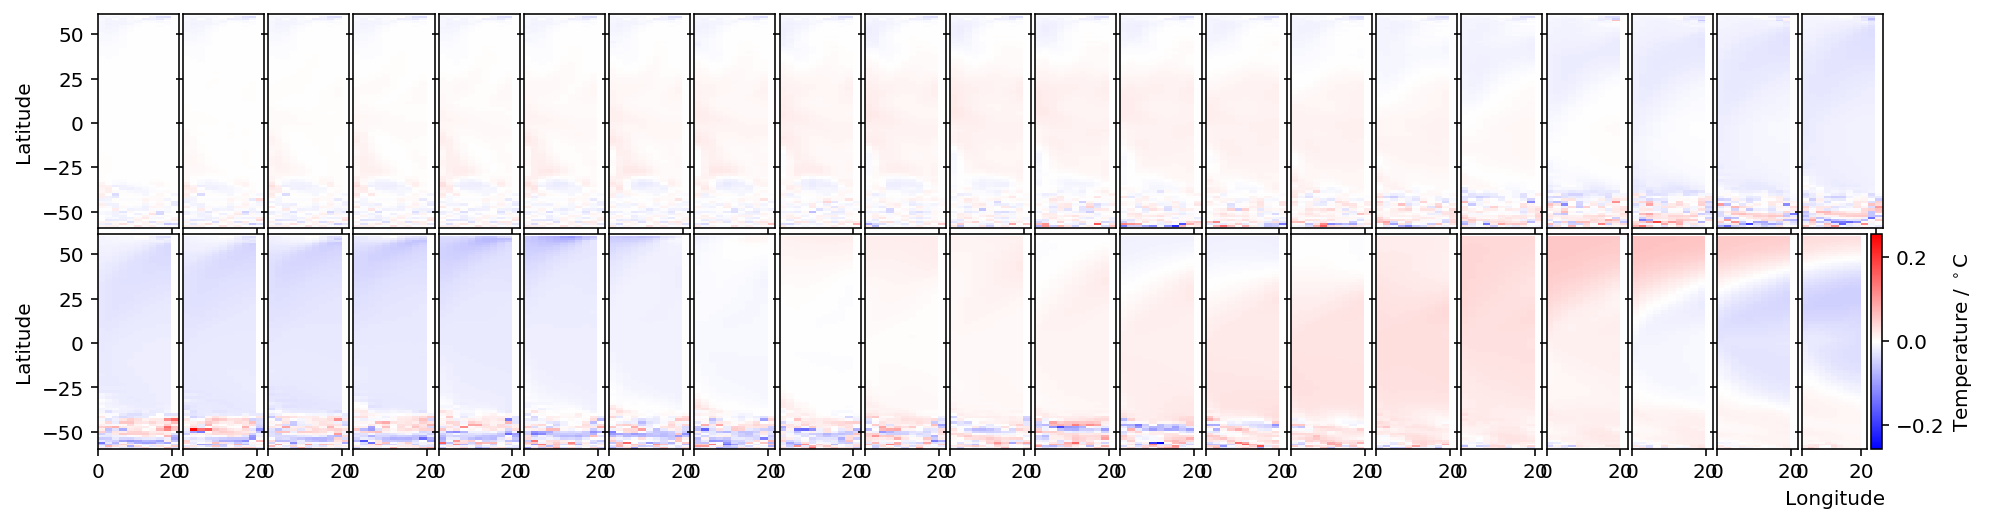

In [145]:
i_t_test = 6000

restoration = numpy.einsum(
    'i,izyx->zyx',
    projection[i_t_test],
    pca_components)

plot_z_layers(restoration - (ttave[i_t_test] - mean), dataset, LABEL_TEMPERATURE, symmetric_about_zero=True)

This is how the exposure to each factor varies over time. Different factors are stationary over different timescales... depending on what we want to predict this could be useful information?

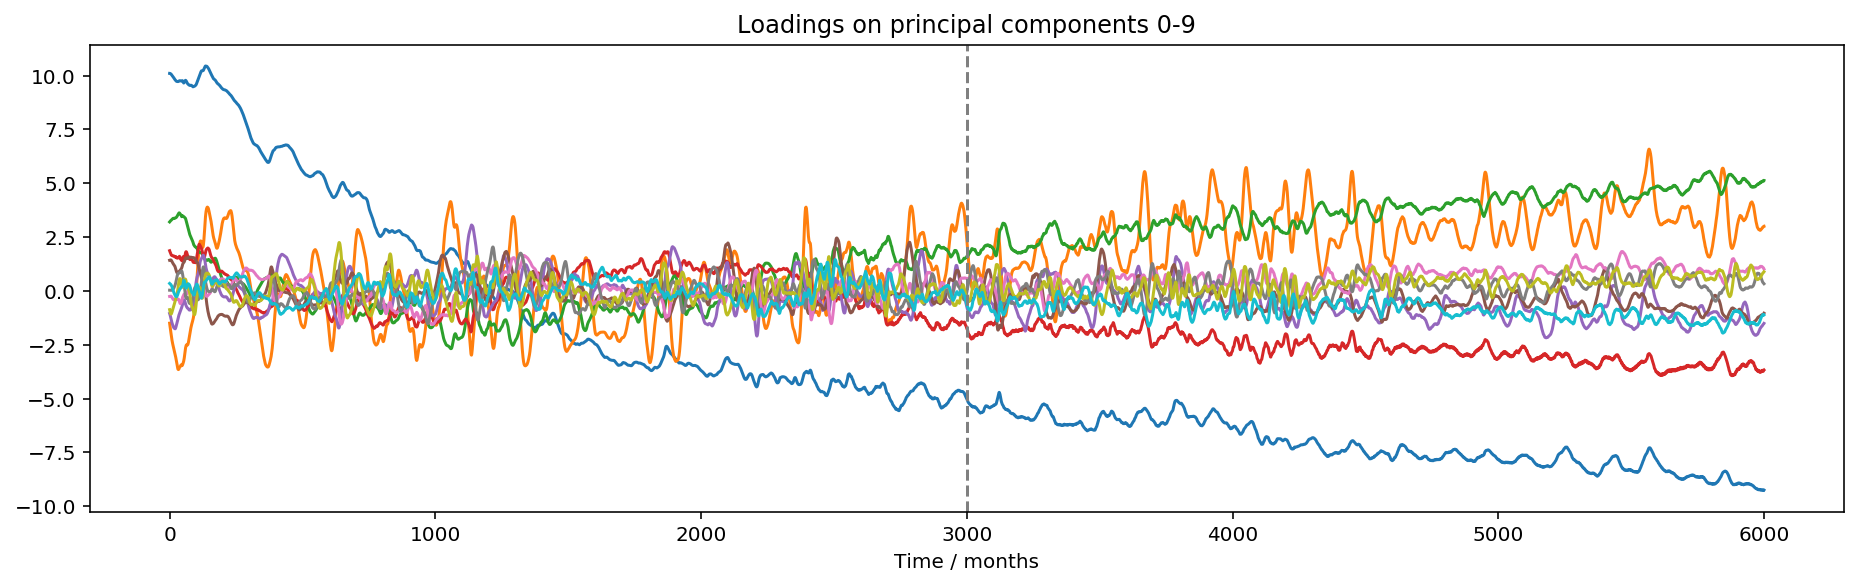

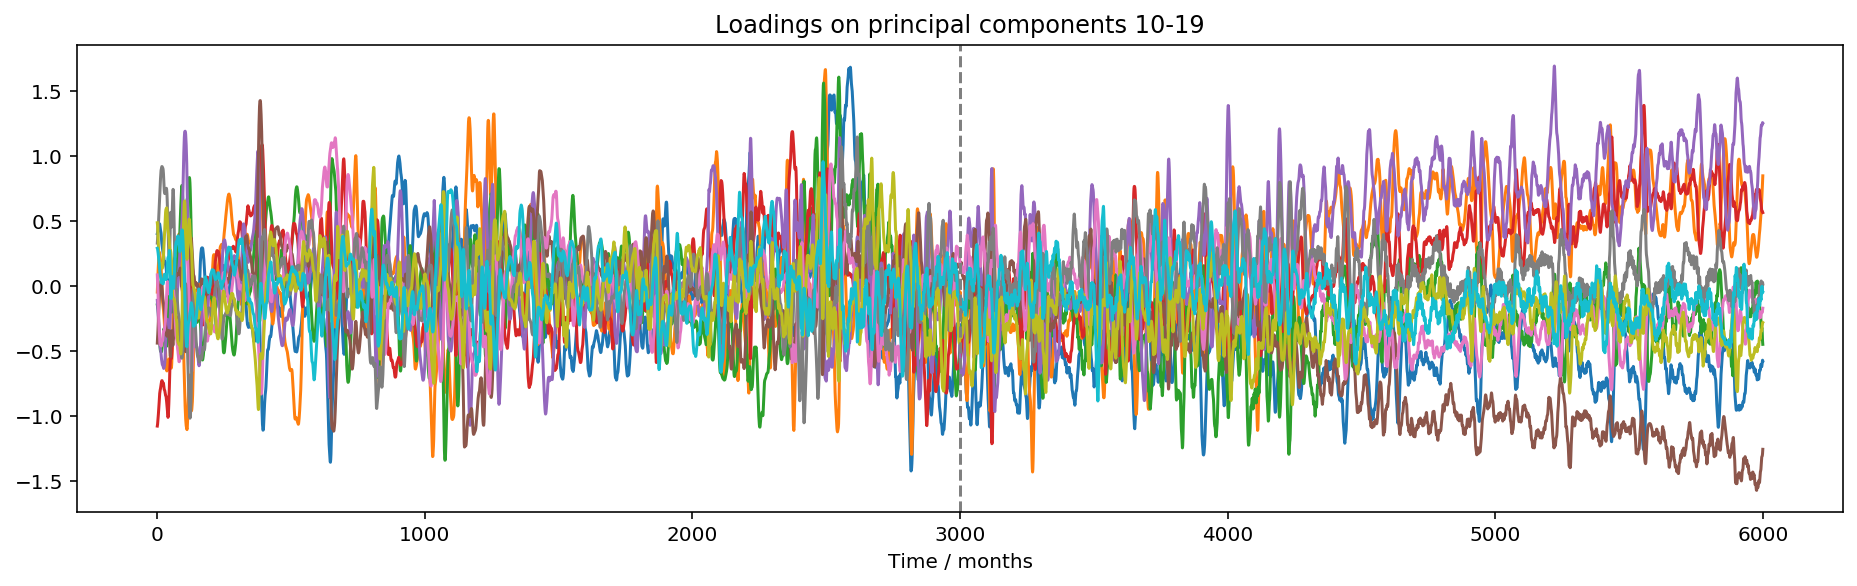

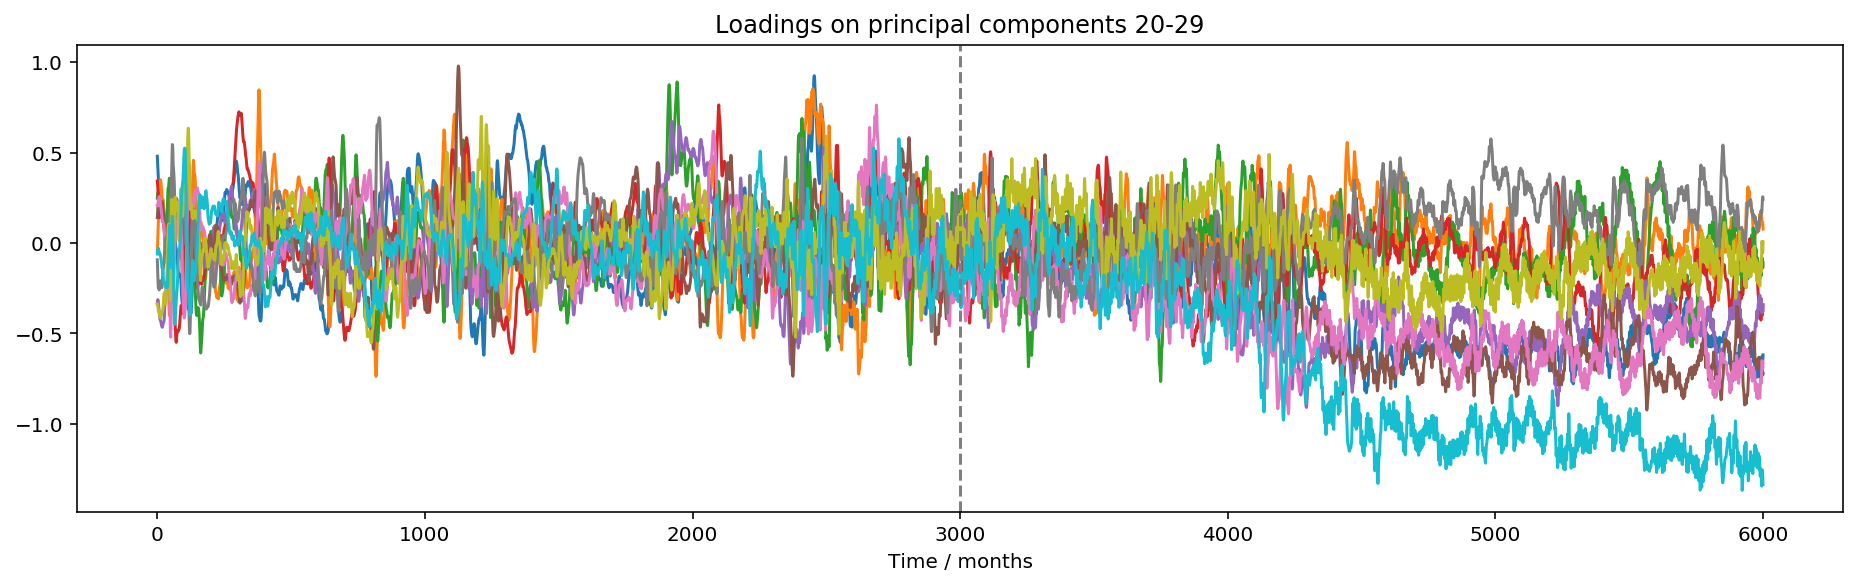

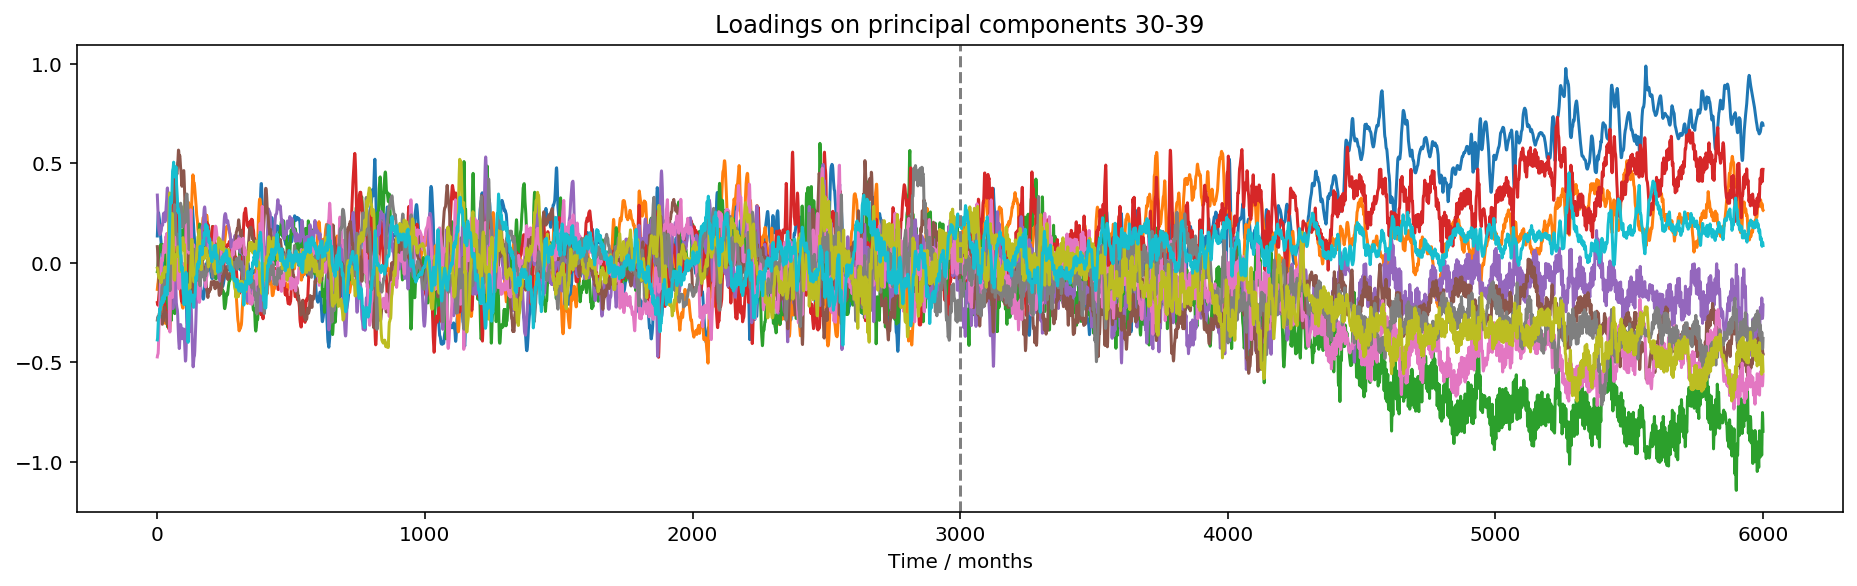

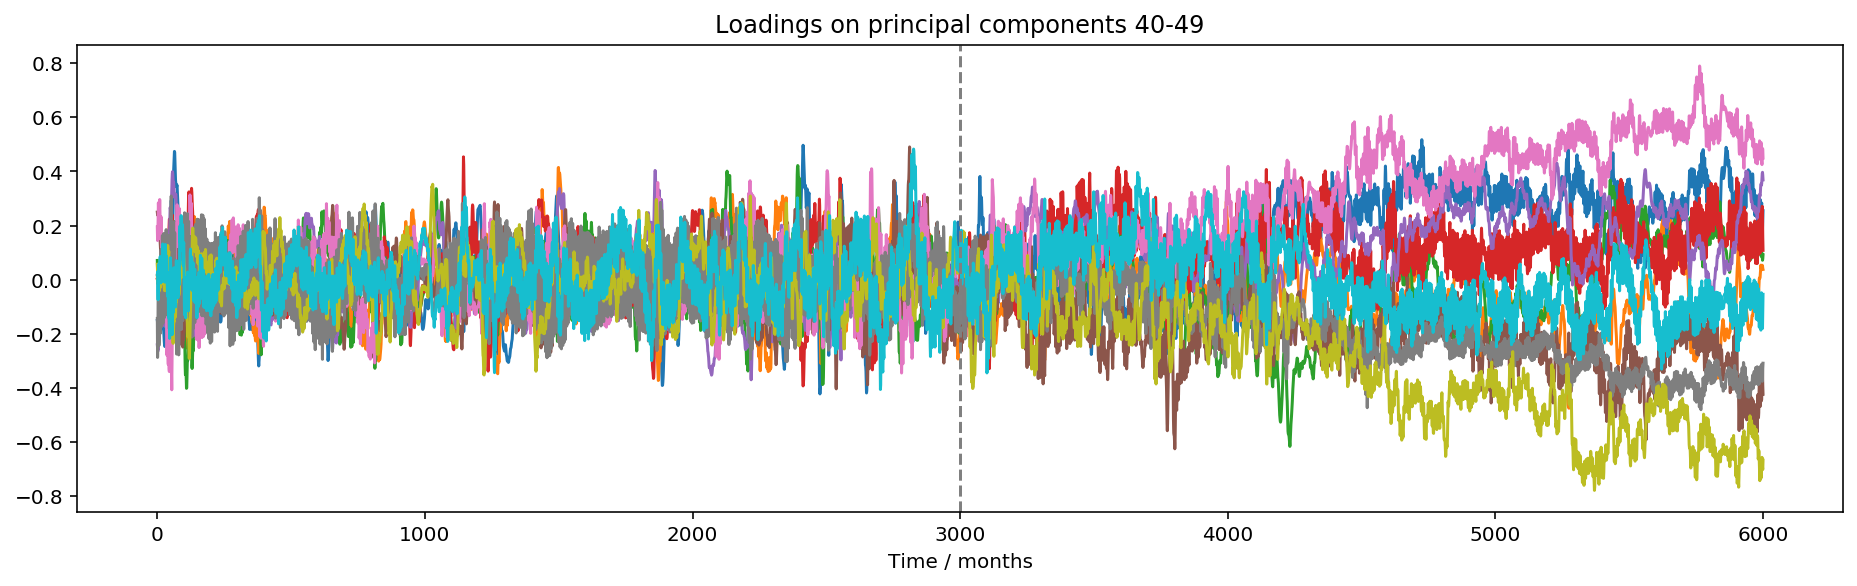

In [146]:
# FactorAnalysis and PCA normalise the factors differently. normalisation will be a vector of ones for PCA (or 
# numerically close to that), but for FactorAnalysis it will be significantly decaying.
normalisation = numpy.sqrt(numpy.sum(pca_components ** 2, axis=(1, 2, 3)))
normalised_projection = projection * normalisation
for index_batch in more_itertools.chunked(range(min(50, normalised_projection.shape[1])), 10):
    pyplot.figure(figsize=(13, 4))
    pyplot.title(f'Loadings on principal components {index_batch[0]}-{index_batch[-1]}')
    pyplot.plot(normalised_projection[:, index_batch])
    pyplot.tight_layout()
    pyplot.xlabel('Time / months')
    pyplot.axvline(i_t_in_sample, color='grey', ls='dashed')
    pyplot.show()

#### Evolution of loadings
Are we able to predict the evolution of the component loadings?

For now, just attempt to predict the difference from one time-step to the next - and evaluate always starting from the *correct* place in phase space. This is a much simpler problem than what we'd ideally want to solve, namely predicting iteratively many steps into the future.

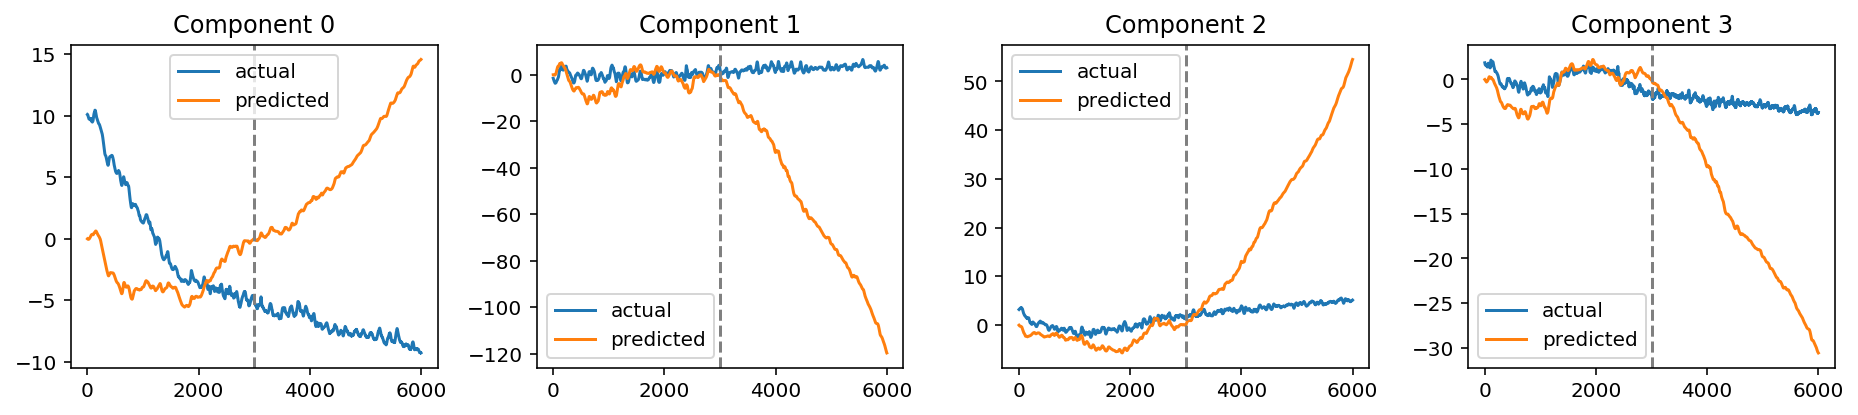

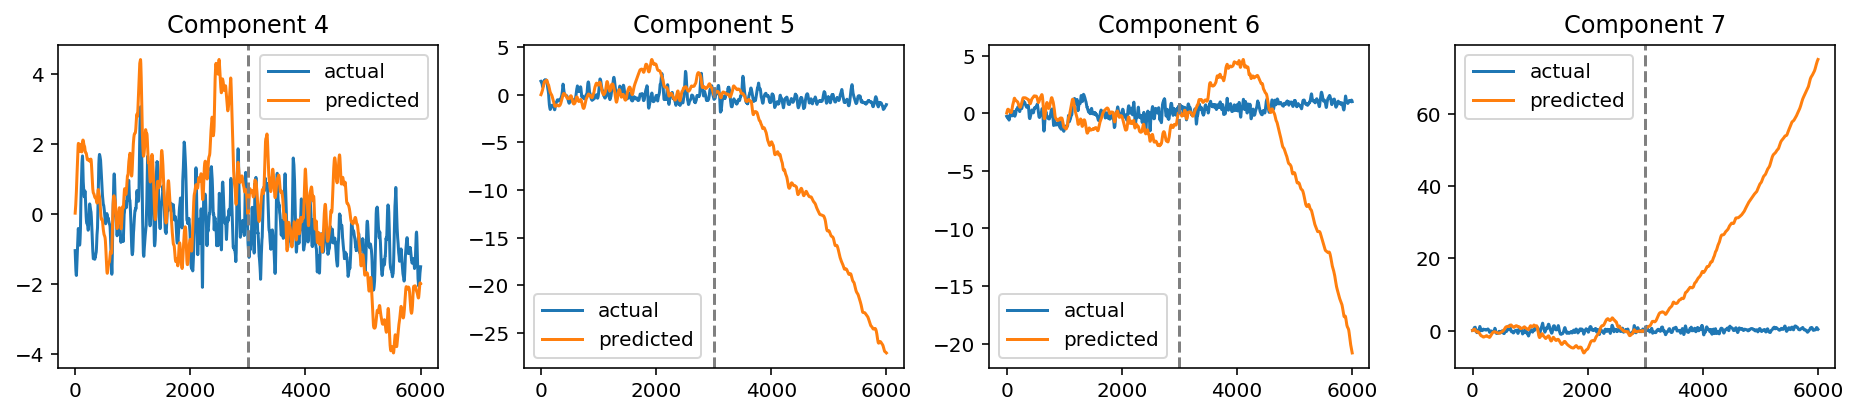

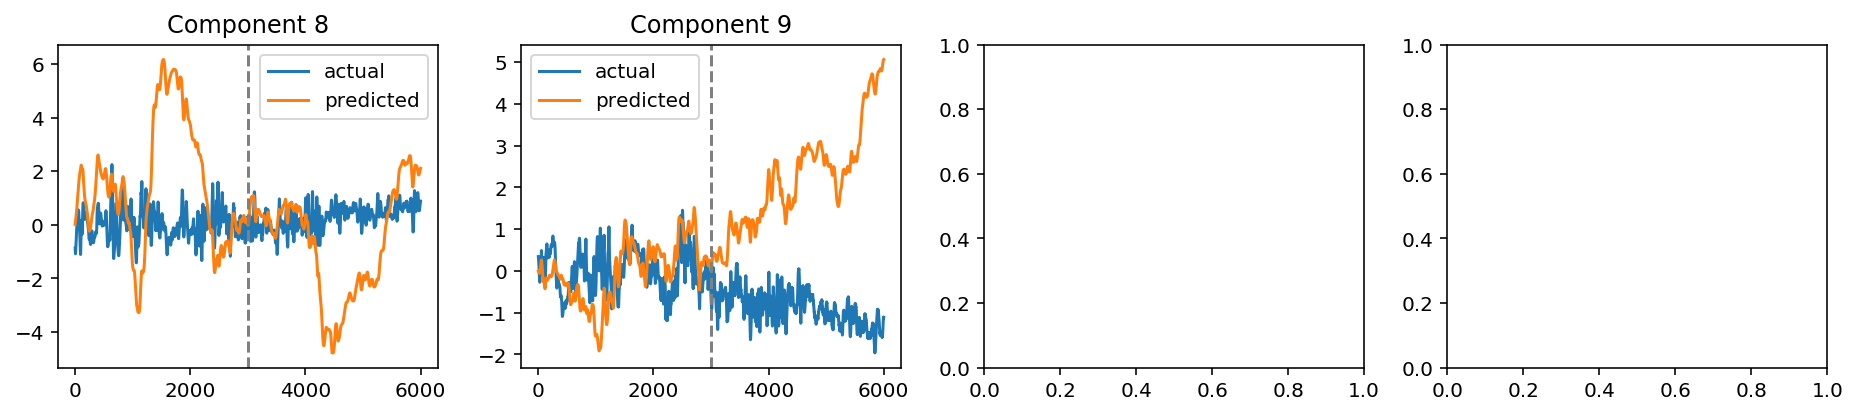

In [147]:
def run_fit(projection: numpy.ndarray):
    # Filter the first few components
    projection = projection[:, :10]
    train_projection = projection[:i_t_in_sample]
    y = numpy.diff(train_projection, axis=0)
    X = train_projection[:-1]

    #     model = linear_model.LinearRegression(fit_intercept=False)
    model = linear_model.HuberRegressor(fit_intercept=False)
    
    for i in axes_iter(range(10), num_cols=4, height=3):
        model.fit(X, y[:, i])
        
        pyplot.title(f'Component {i}')
        pyplot.plot(projection[:, i], label='actual')
        pyplot.plot(numpy.cumsum(model.predict(projection))[:], label='predicted')
        pyplot.axvline(i_t_in_sample, ls='dashed', color='grey')
        pyplot.legend()
    
run_fit(projection)

# Factor analysis

In [148]:
model_factor = decomposition.FactorAnalysis(50)
model_factor.fit(flat_ttave[:i_t_in_sample])

FactorAnalysis(copy=True, iterated_power=3, max_iter=1000, n_components=50,
               noise_variance_init=None, random_state=0,
               svd_method='randomized', tol=0.01)

### Noise variance
For FactorAnalysis, internally we estimate the variance of each feature. We plot the square root of this.

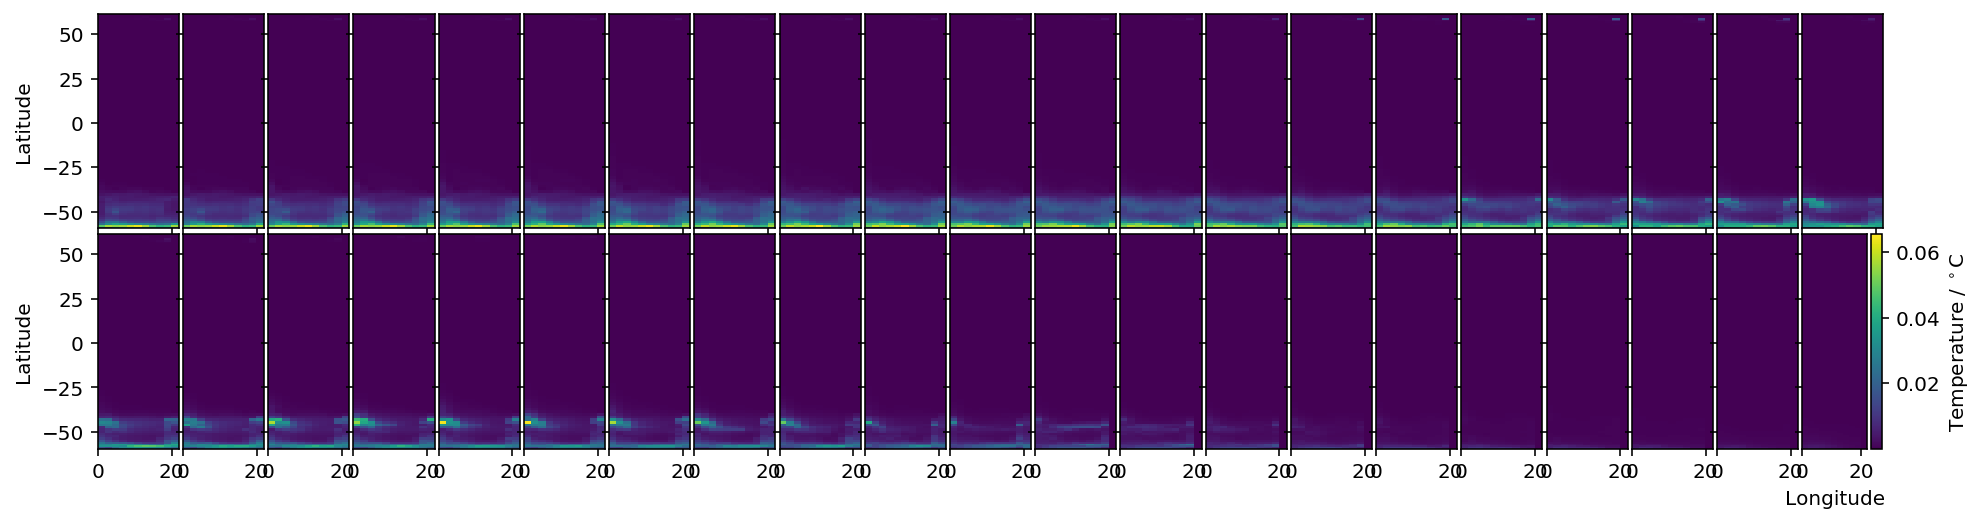

In [149]:
plot_z_layers(
    numpy.sqrt(model_factor.noise_variance_).reshape(ttave.shape[1:]),
    dataset,
    LABEL_TEMPERATURE)

In [150]:
# FactorAnalysis and PCA normalise the factors differently. normalisation will be a vector of ones for PCA (or 
# numerically close to that), but for FactorAnalysis it will be significantly decaying.
normalisation_factor = numpy.sqrt(numpy.sum(model_factor.components_ ** 2, axis=1))

Factor component: 0


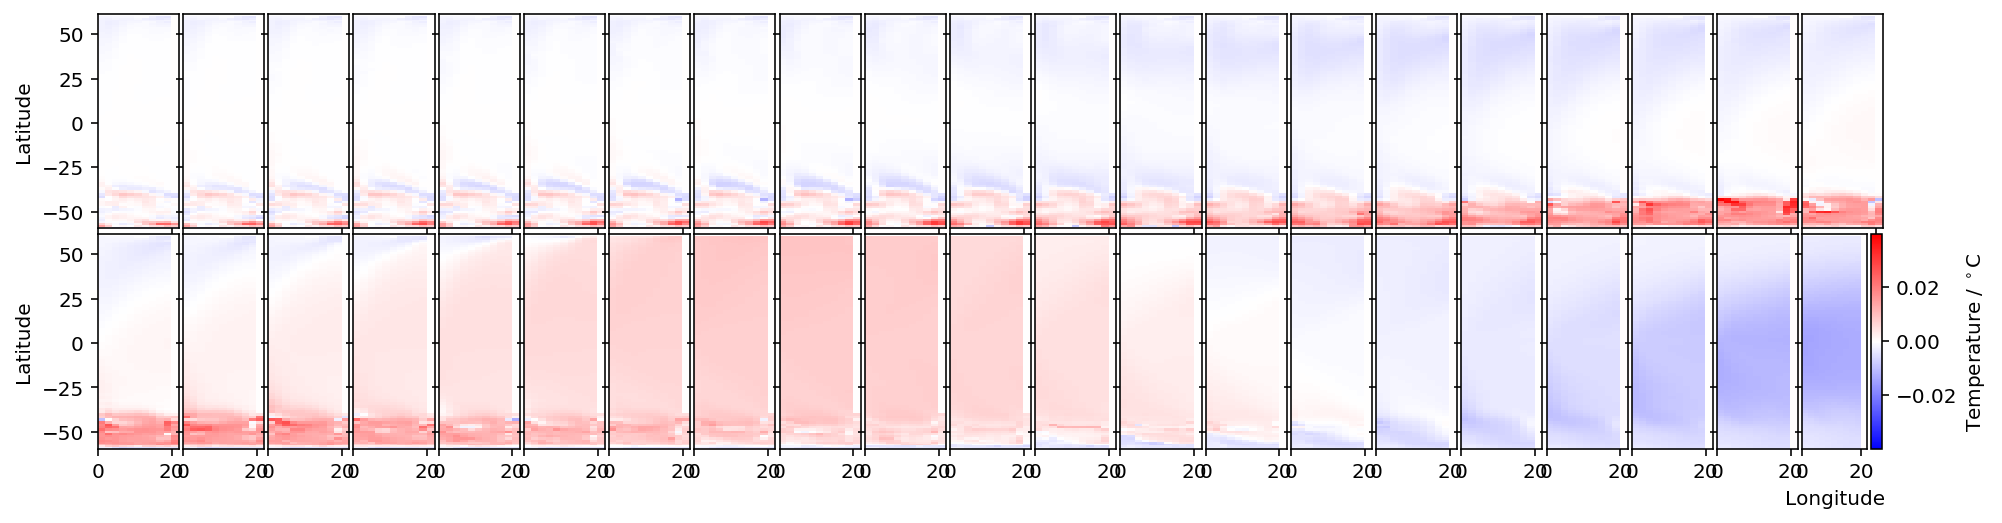


Factor component: 1


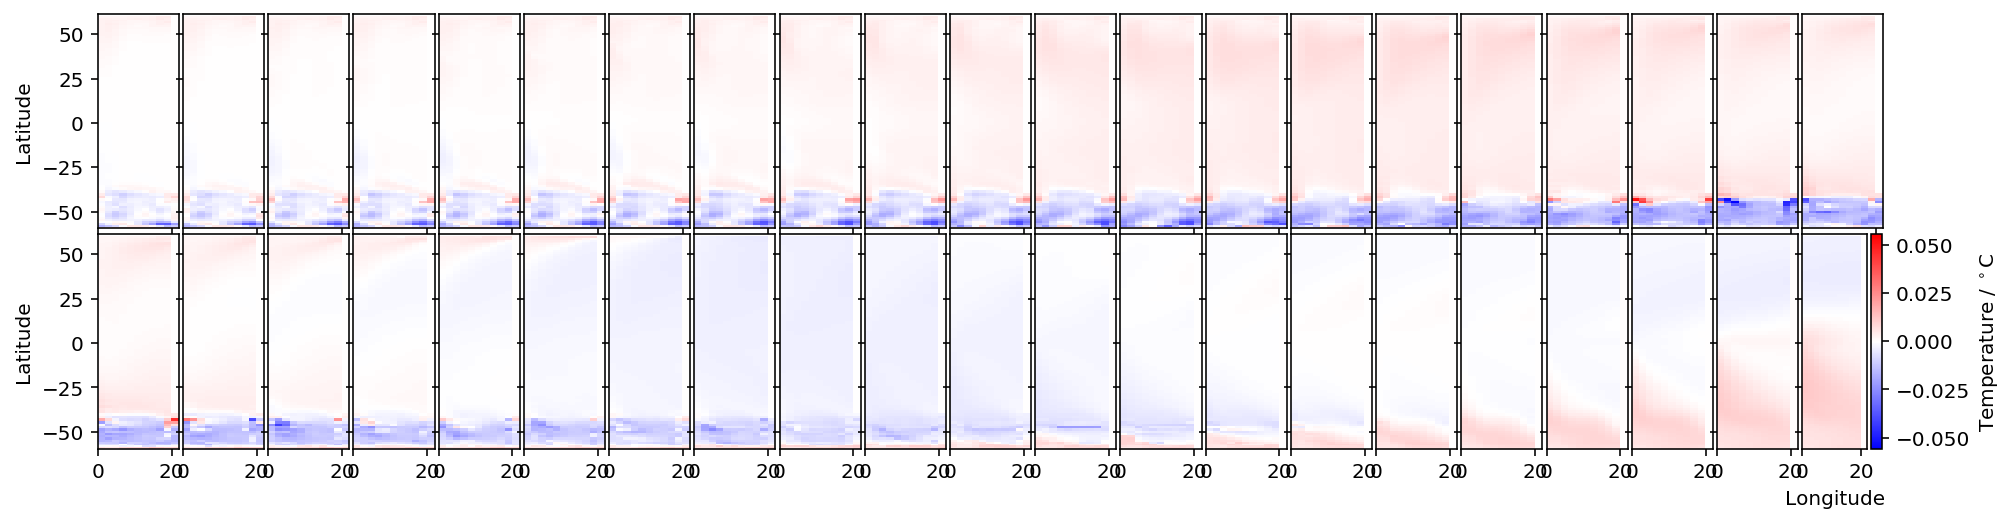


Factor component: 2


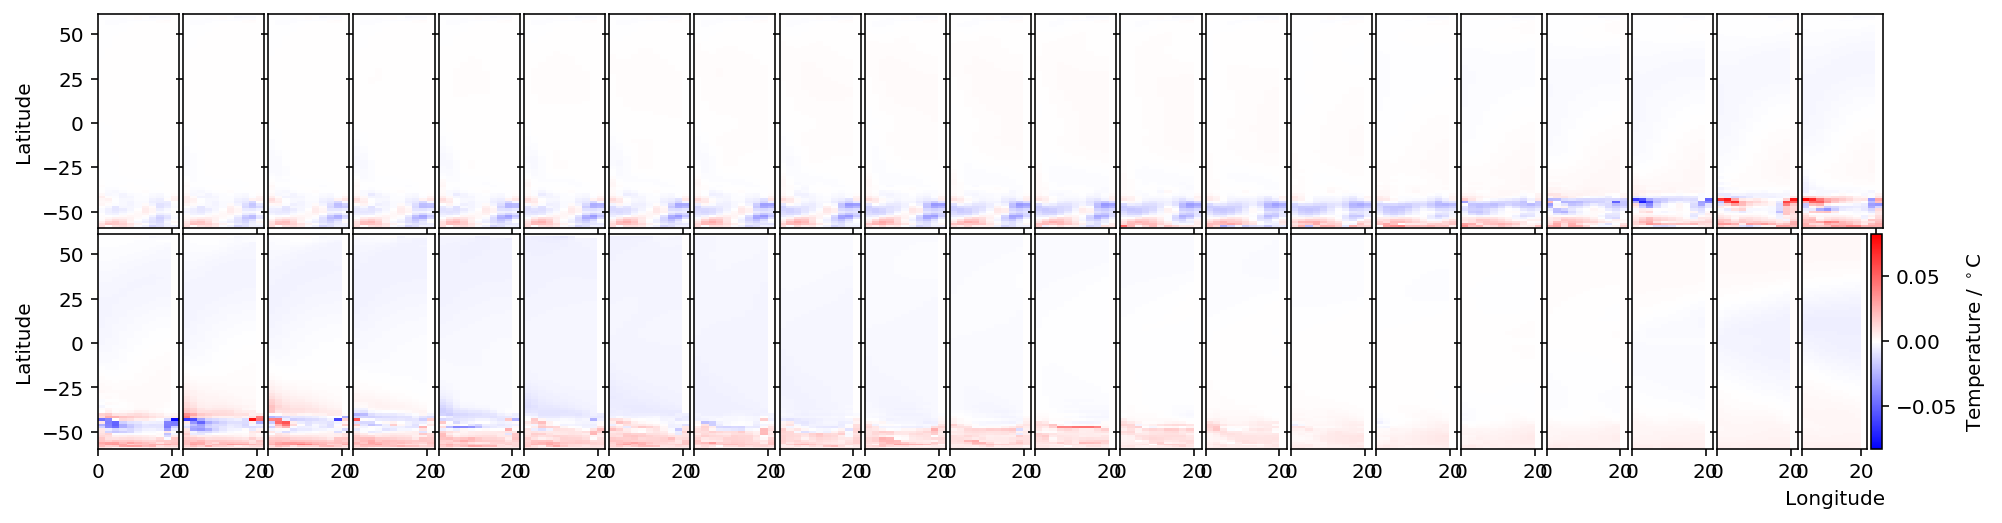


Factor component: 3


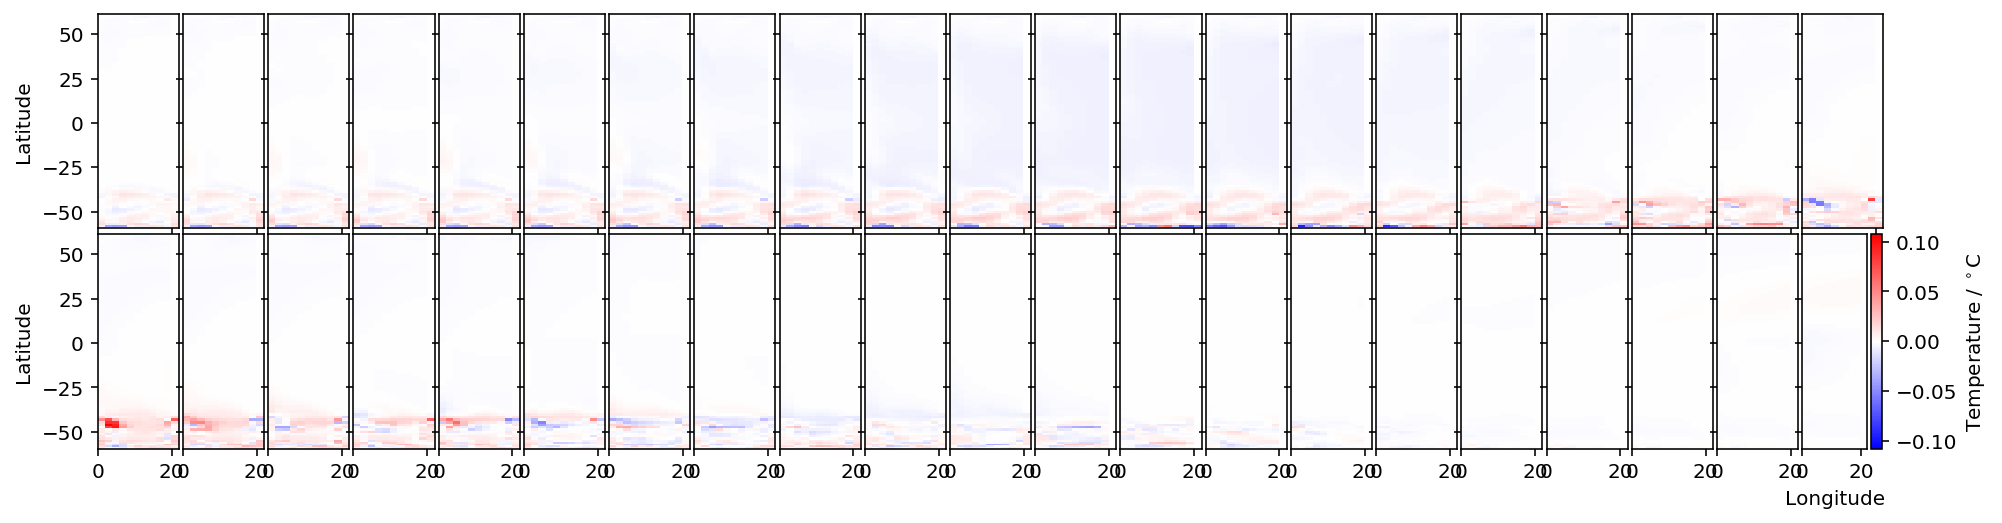


Factor component: 4


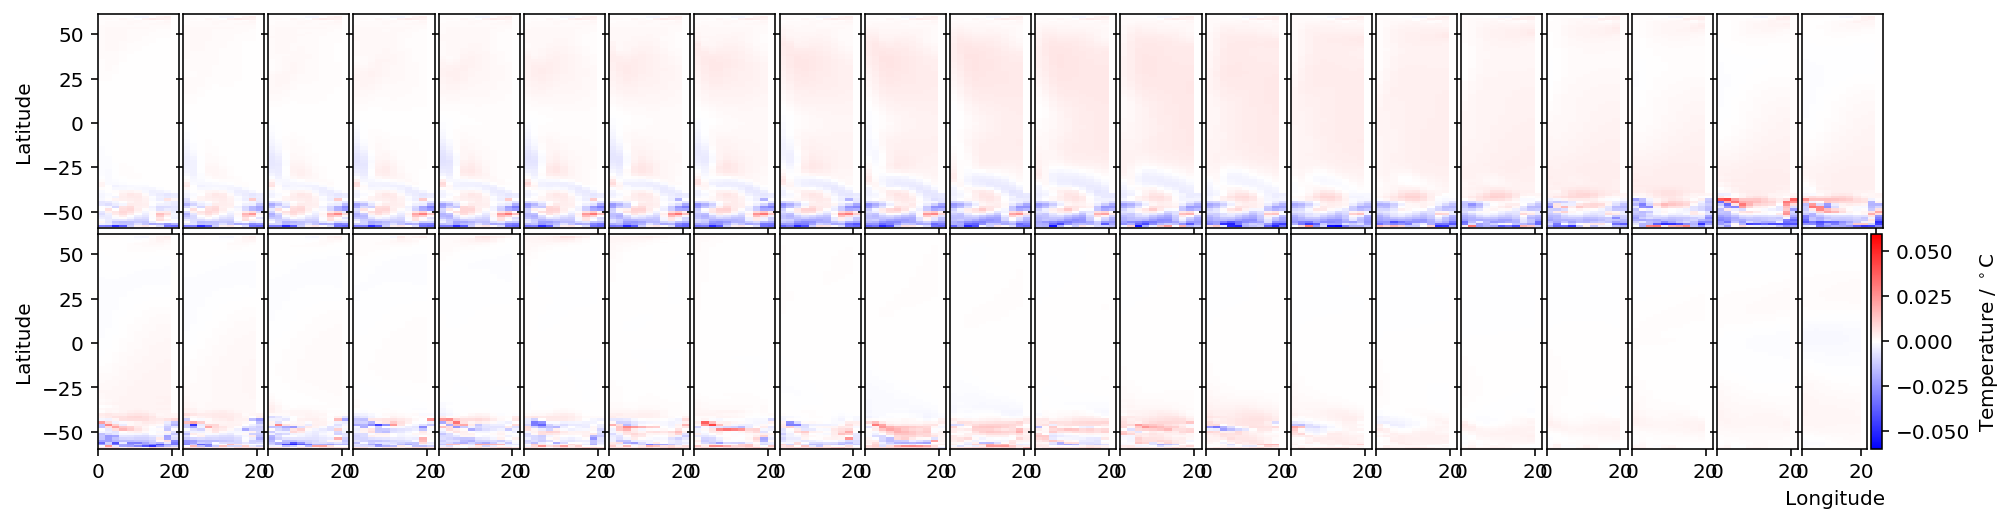

In [151]:
factor_components = (model_factor.components_ / numpy.expand_dims(normalisation_factor, axis=1)).reshape(-1, *ttave.shape[1:])
for i_fc, fc in enumerate(factor_components[:5]):
    print(f'Factor component: {i_fc}')
    plot_z_layers(fc, dataset, LABEL_TEMPERATURE, symmetric_about_zero=True)
    pyplot.show()
    print()

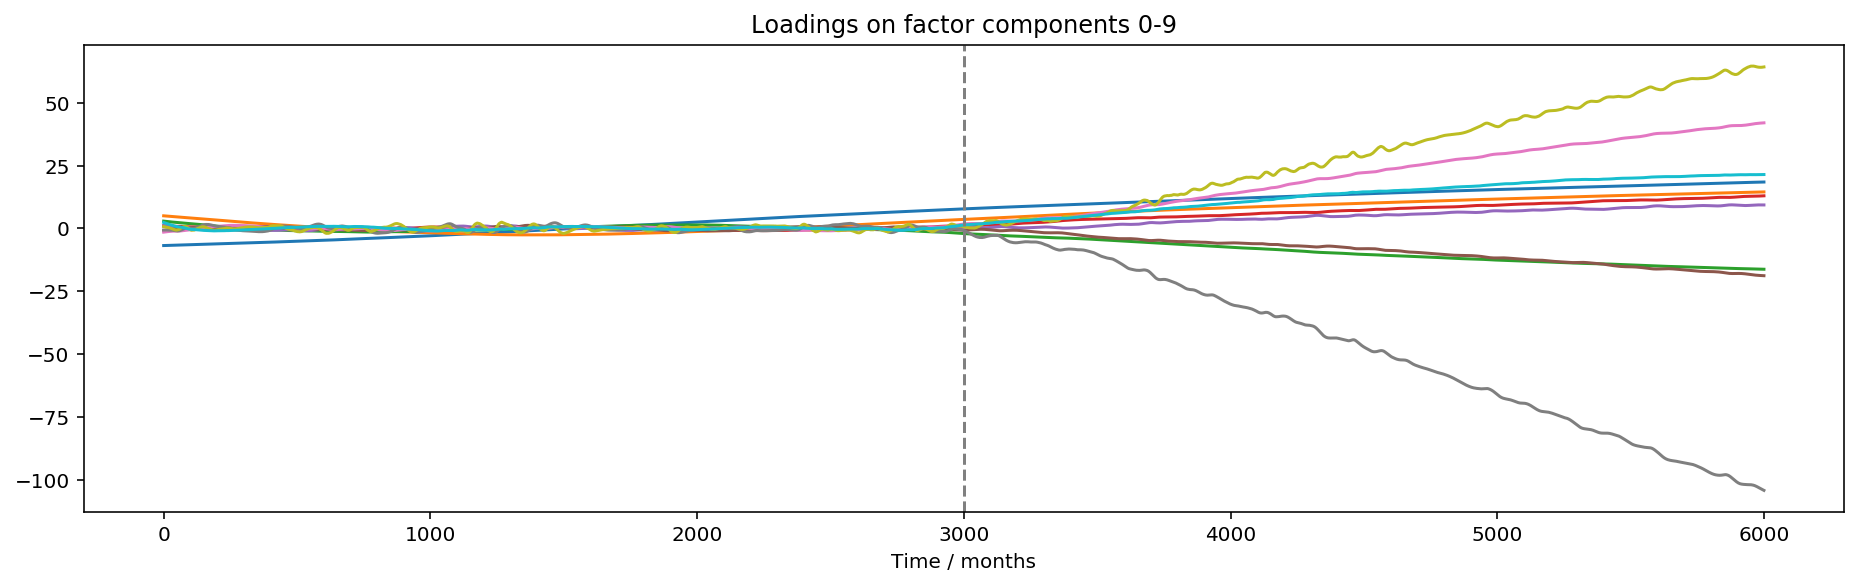

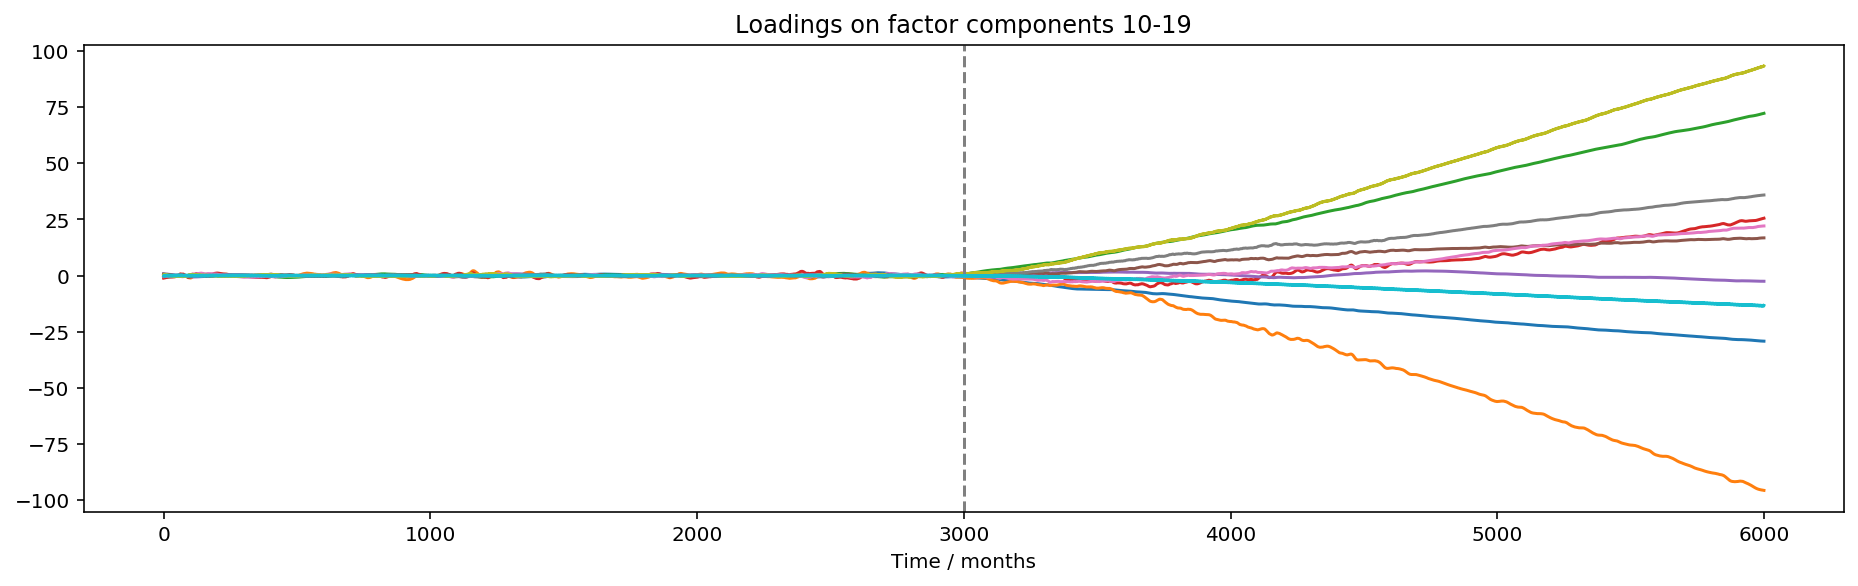

In [152]:
projection_factor = model_factor.transform(flat_ttave)

normalised_projection_factor = projection_factor * normalisation_factor
for index_batch in more_itertools.chunked(range(min(20, normalised_projection_factor.shape[1])), 10):
    pyplot.figure(figsize=(13, 4))
    pyplot.title(f'Loadings on factor components {index_batch[0]}-{index_batch[-1]}')
    pyplot.plot(normalised_projection_factor[:, index_batch])
    pyplot.axvline(i_t_in_sample, color='grey', ls='dashed')
    pyplot.tight_layout()
    pyplot.xlabel('Time / months')
    pyplot.show()